In [297]:
import matplotlib.pyplot as plt
import sys
import torch
import numpy as np
import imageio
import os

First we'll graph the mean squared errors of our four models by day.

In [350]:
sys.path.insert(0, '../no_model')

In [351]:
sys.path.insert(0, '../conv3d')

In [352]:
sys.path.insert(0, '../convlstm')

In [353]:
sys.path.insert(0, '../encoder_decoder')

In [354]:
baseline_errors = []
with open('baseline_errors.txt', 'r') as f:
    for line in f:
        baseline_errors.append(float(line))

In [355]:
conv3d_errors = []
with open('conv3d_errors.txt', 'r') as f:
    for line in f:
        conv3d_errors.append(float(line))

In [356]:
convlstm_errors = []
with open('convlstm_errors.txt', 'r') as f:
    for line in f:
        convlstm_errors.append(float(line))

In [357]:
encoder_decoder_errors = []
with open('encoder_decoder_errors.txt', 'r') as f:
    for line in f:
        encoder_decoder_errors.append(float(line))

In [358]:
print('Mean squared error by day\n')
for i in range(30):
    print(f'Day {i+1}')
    print(f'Mean squared error by day for baseline model: {baseline_errors[i]:.5f}')
    print(f'Mean squared error by day for ConvLSTM model: {convlstm_errors[i]:.5f}')
    print(f'Mean squared error by day for Encoder-decoder model: {encoder_decoder_errors[i]:.5f}')
    print(f'Mean squared error by day for Conv3d model: {conv3d_errors[i]:.5f}\n')

Mean squared error by day

Day 1
Mean squared error by day for baseline model: 0.00165
Mean squared error by day for ConvLSTM model: 0.00346
Mean squared error by day for Encoder-decoder model: 0.00190
Mean squared error by day for Conv3d model: 0.00166

Day 2
Mean squared error by day for baseline model: 0.00531
Mean squared error by day for ConvLSTM model: 0.00790
Mean squared error by day for Encoder-decoder model: 0.00578
Mean squared error by day for Conv3d model: 0.00533

Day 3
Mean squared error by day for baseline model: 0.00927
Mean squared error by day for ConvLSTM model: 0.01180
Mean squared error by day for Encoder-decoder model: 0.01005
Mean squared error by day for Conv3d model: 0.00932

Day 4
Mean squared error by day for baseline model: 0.01313
Mean squared error by day for ConvLSTM model: 0.01517
Mean squared error by day for Encoder-decoder model: 0.01396
Mean squared error by day for Conv3d model: 0.01313

Day 5
Mean squared error by day for baseline model: 0.01694
M

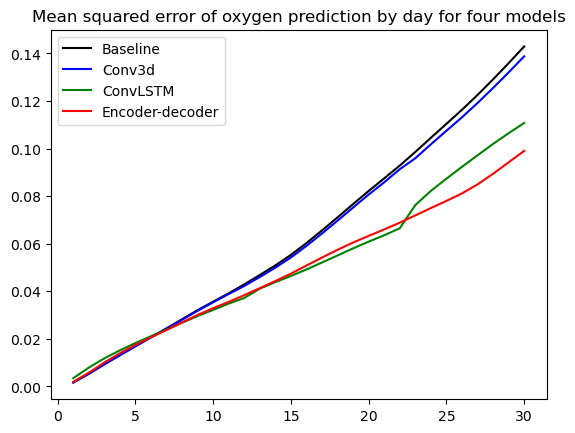

In [359]:
plt.plot(range(1,31,1), baseline_errors, label='Baseline', color='black')
plt.plot(range(1,31,1), conv3d_errors, label='Conv3d', color='blue')
plt.plot(range(1,31,1), convlstm_errors, label='ConvLSTM', color='green')
plt.plot(range(1,31,1), encoder_decoder_errors, label='Encoder-decoder', color='red')
plt.legend()
plt.title('Mean squared error of oxygen prediction by day for four models')
plt.savefig('mse_comparison.pdf', format='pdf')

In [360]:
print(f'Baseline mean squared error: {np.mean(baseline_errors):.5f}')
print(f'Conv3d mean squared error: {np.mean(conv3d_errors):.5f}')
print(f'ConvLSTM mean squared error: {np.mean(convlstm_errors):.5f}')
print(f'Encoder-decoder mean squared error: {np.mean(encoder_decoder_errors):.5f}')

with open('mean_squared_errors.txt', 'w') as f:
    f.write(f'Baseline mean squared error: {np.mean(baseline_errors):.5f}\n')
    f.write(f'Conv3d mean squared error: {np.mean(conv3d_errors):.5f}\n')
    f.write(f'ConvLSTM mean squared error: {np.mean(convlstm_errors):.5f}\n')
    f.write(f'Encoder-decoder mean squared error: {np.mean(encoder_decoder_errors):.5f}')

Baseline mean squared error: 0.06396
Conv3d mean squared error: 0.06258
ConvLSTM mean squared error: 0.05177
Encoder-decoder mean squared error: 0.04950


The encoder-decoder model has the lowest overall mean-squared error. It also has the lowest mean-squared error for most dates in our 30-day range.

Now we'll create some gifs to compare the predictions of the three models ConvLSTM, Encoder-decoder, and Conv3D over time.

In [393]:
dataset = torch.tensor(np.load('../../numpy_dataset/dataset.npy'))

In [394]:
dataset_norm = torch.tensor(np.load('../../numpy_dataset/dataset_normalized.npy'))

In [395]:
X = dataset_norm[:,:11,:,:,:]

In [396]:
y = dataset_norm[:,11:,:,:,:]

X_perm here is used for the Conv3D model which expects input of a different shape.

In [397]:
X_perm = torch.permute(X, (0,2,1,3,4))

y_un will be used to mask the predicted outputs of the different models.

In [398]:
y_un = dataset[:,11:,:,:,:]

Here we set up our three different models.

In [399]:
from conv3d_classes import Conv3dModel

In [400]:
from convlstm_classes import ConvLSTM

In [401]:
from encoder_decoder_classes import EncoderDecoderConvLSTM

In [402]:
conv3d_model = Conv3dModel()

In [403]:
convlstm_model = ConvLSTM(input_dim=8, hidden_dim=8, kernel_size=(3,3), num_layers=3,
                          batch_first=True, bias=True, return_all_layers=True, dropout_prob=0.3,
                          output_size=30, output_channel=1)

In [404]:
encoder_decoder_model = EncoderDecoderConvLSTM()

In [405]:
conv3d_model.load_state_dict(torch.load('../conv3d/best_model_params.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [406]:
convlstm_model.load_state_dict(torch.load('../convlstm/best_model_params.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [407]:
encoder_decoder_model.load_state_dict(torch.load('../encoder_decoder/best_model_params.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [408]:
for model in [conv3d_model, convlstm_model, encoder_decoder_model]:
    model.eval()

Now we compute the predictions of each model over a range of 20 randomly chosen dates in the test set. We will produce an animation of the predictions of each model (30 days into the future) against the true O2.

In [409]:
test_len = int(len(X) * 0.2)

In [410]:
the_range = list(range(len(X) - test_len, len(X)))

In [411]:
np.random.seed(42)

sample_indices will give us our 20 randomly chosen dates.

In [333]:
sample_indices = np.random.choice(the_range, size=20, replace=False)

In [412]:
y_pred_convlstm = convlstm_model(X[sample_indices]).detach().numpy()

In [413]:
y_pred_encoder_decoder = encoder_decoder_model(X[sample_indices]).squeeze(2).detach().numpy()

In [414]:
y_pred_conv3d = conv3d_model(X_perm[sample_indices]).detach().numpy()

In [415]:
y_true = y[sample_indices,:,1].detach().numpy()

In [416]:
for_mask = y_un[sample_indices,:,1]

In [417]:
y_pred_base = np.ma.masked_where(for_mask.isnan(), y_pred_base)

In [418]:
y_pred_convlstm = np.ma.masked_where(for_mask.isnan(), y_pred_convlstm)

In [419]:
y_pred_encoder_decoder = np.ma.masked_where(for_mask.isnan(), y_pred_encoder_decoder)

In [420]:
y_pred_conv3d = np.ma.masked_where(for_mask.isnan(), y_pred_conv3d)

In [421]:
y_true = np.ma.masked_where(for_mask.isnan(), y_true)

In [422]:
cmap = plt.get_cmap('Blues')

In [423]:
cmap.set_bad(color='green')

In the following two cells we create frames for our gifs and then create the gifs themselves.

/var/folders/h9/7qb3ygvs0mzb0cdjbh8z8svr0000gn/T/ipykernel_43671/3372794564.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1,4)


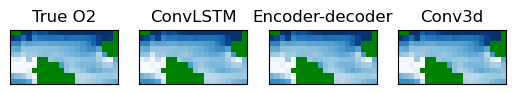

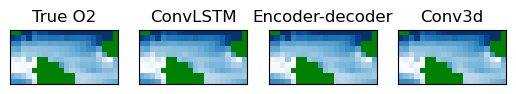

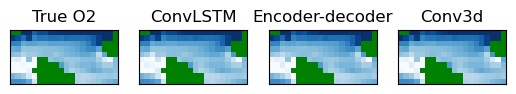

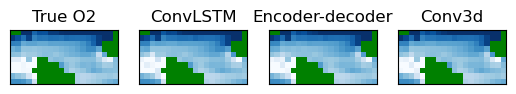

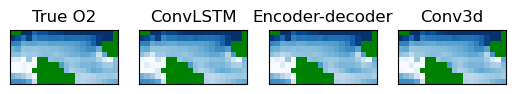

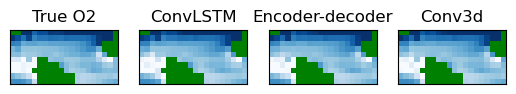

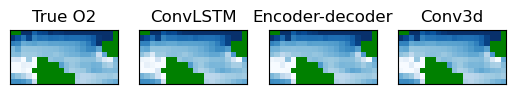

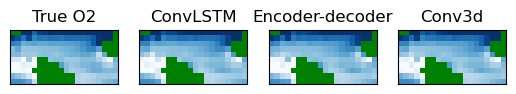

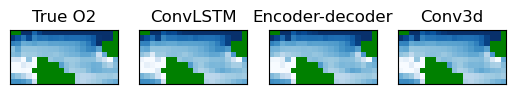

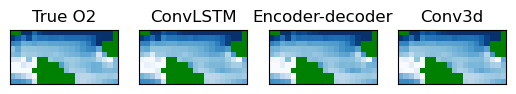

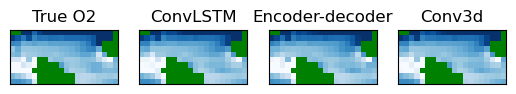

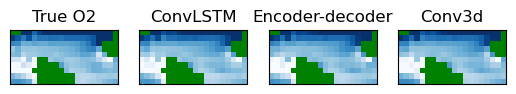

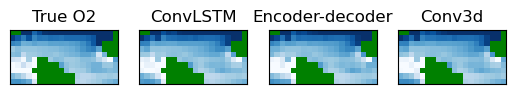

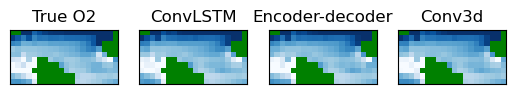

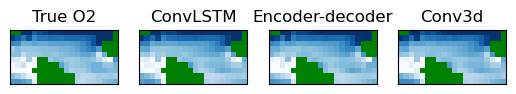

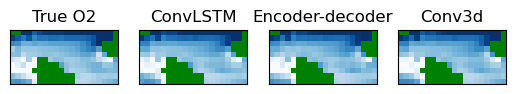

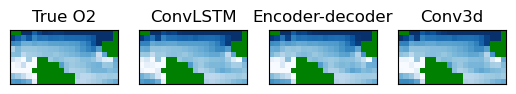

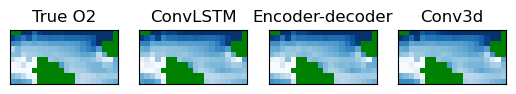

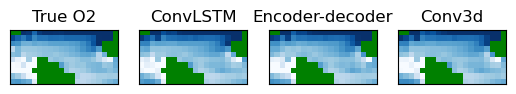

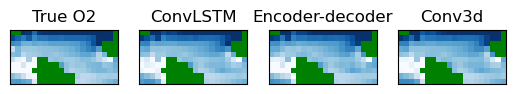

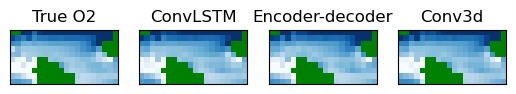

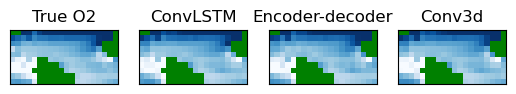

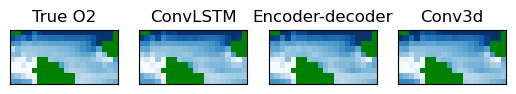

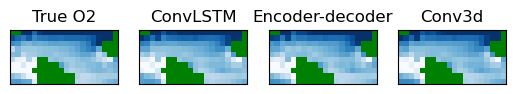

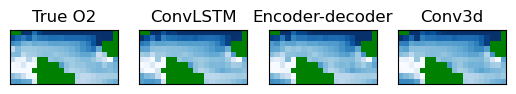

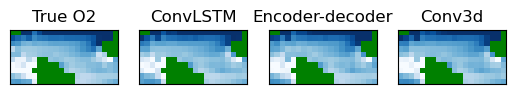

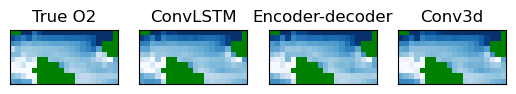

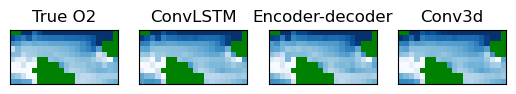

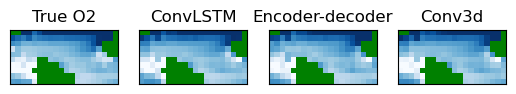

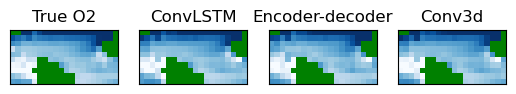

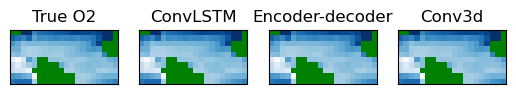

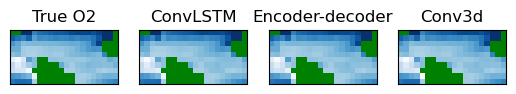

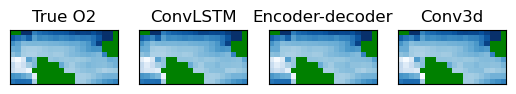

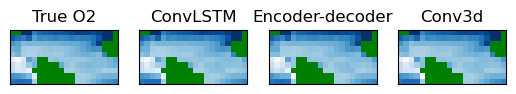

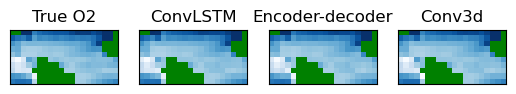

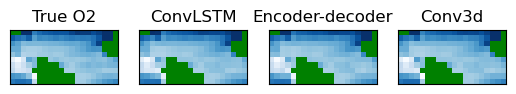

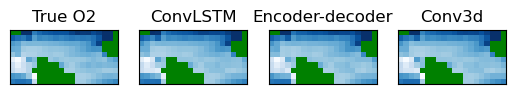

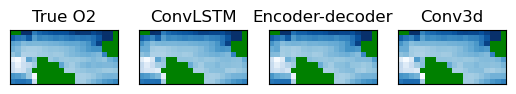

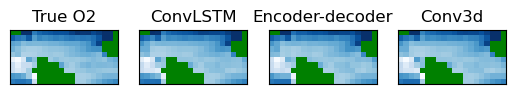

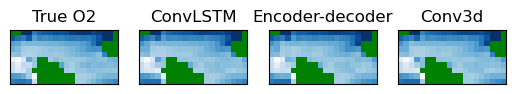

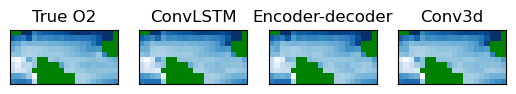

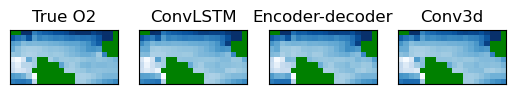

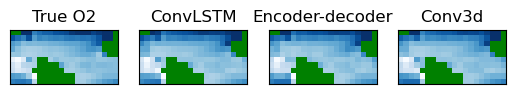

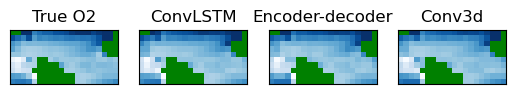

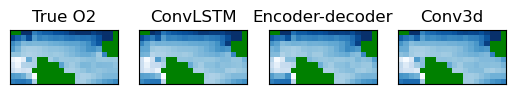

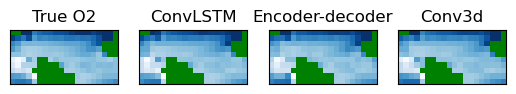

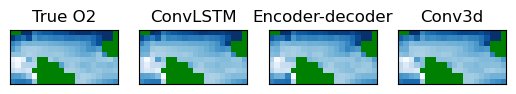

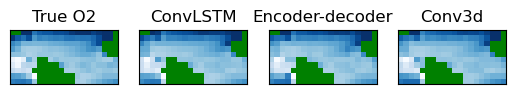

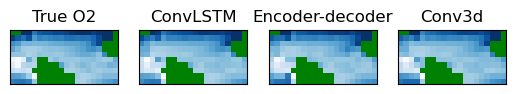

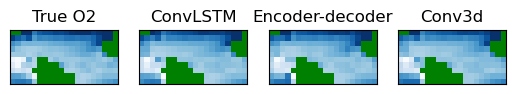

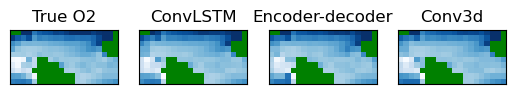

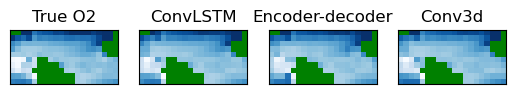

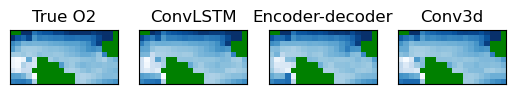

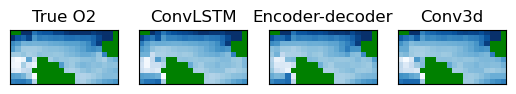

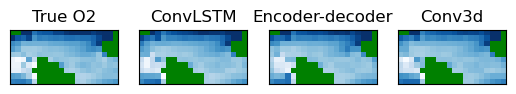

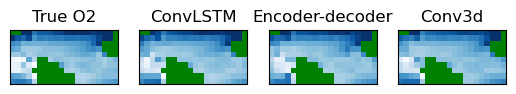

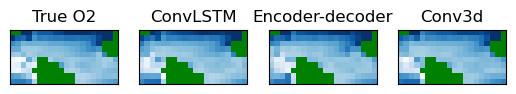

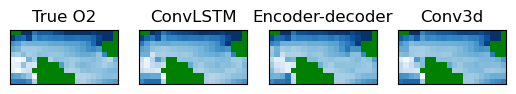

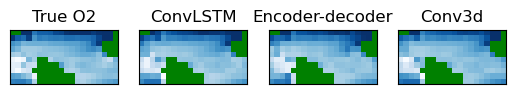

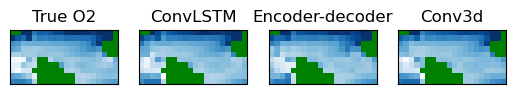

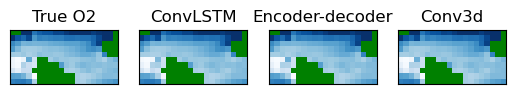

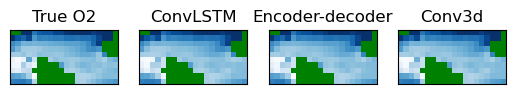

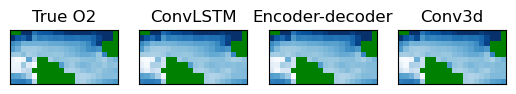

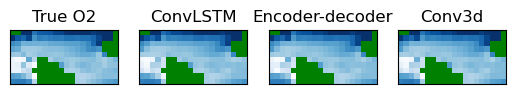

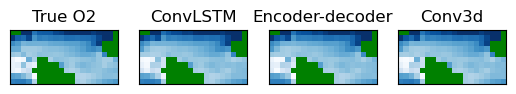

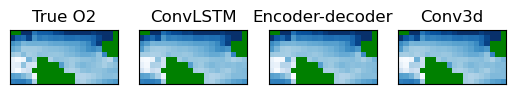

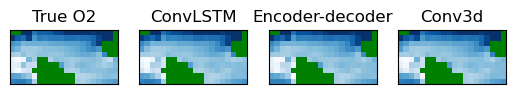

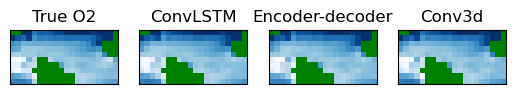

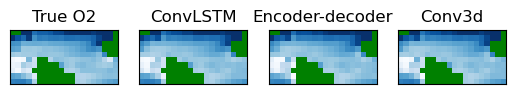

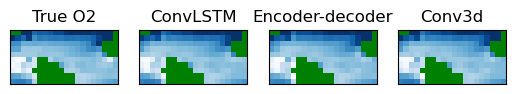

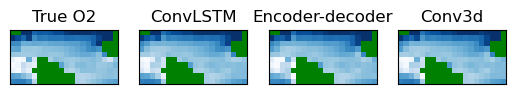

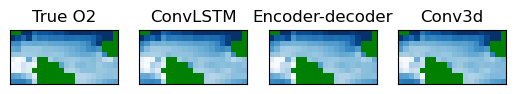

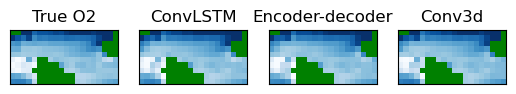

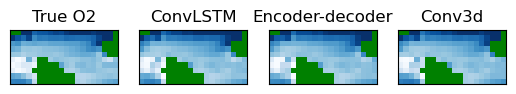

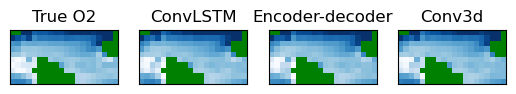

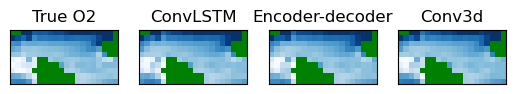

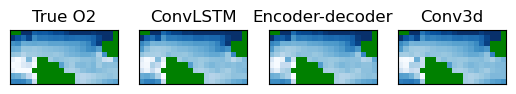

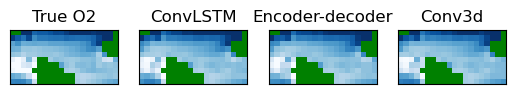

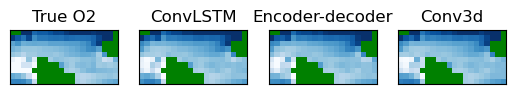

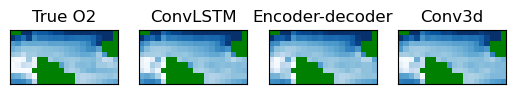

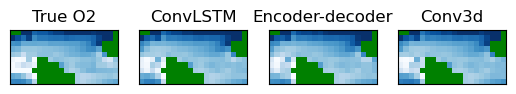

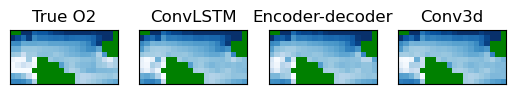

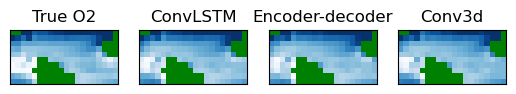

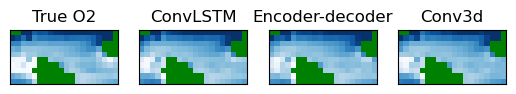

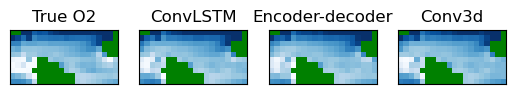

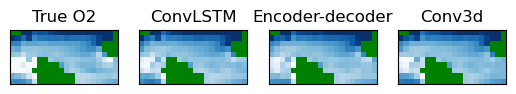

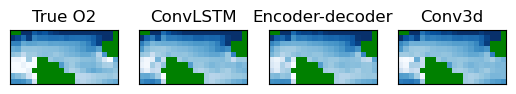

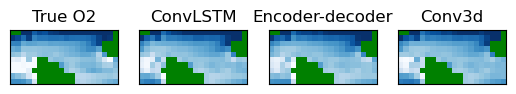

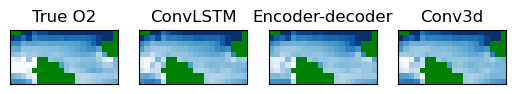

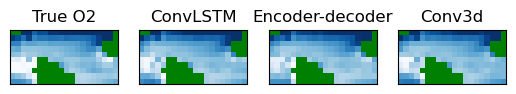

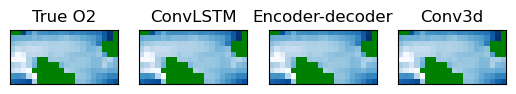

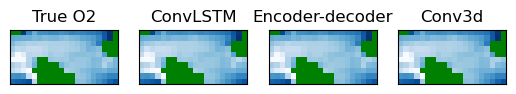

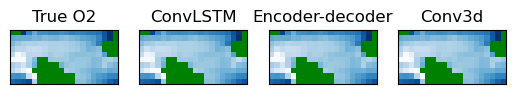

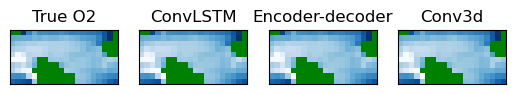

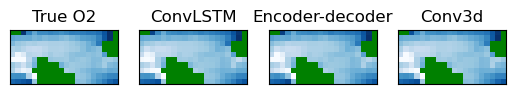

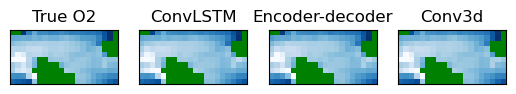

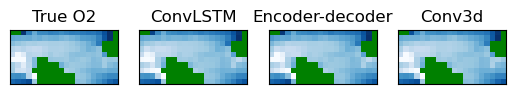

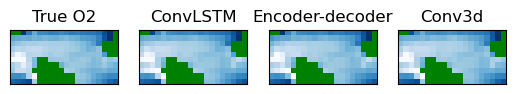

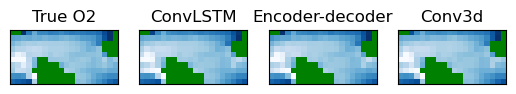

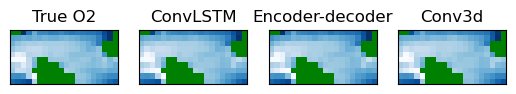

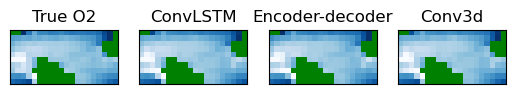

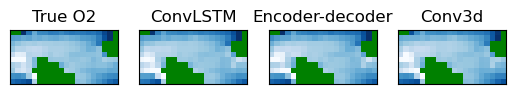

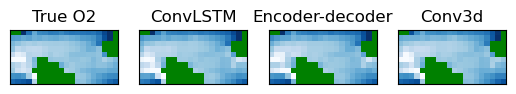

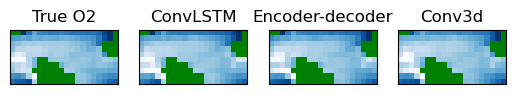

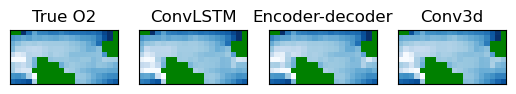

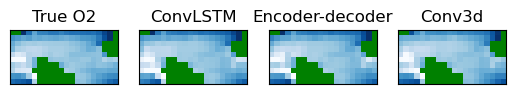

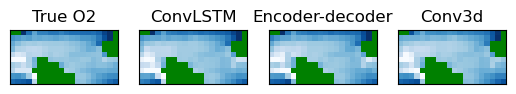

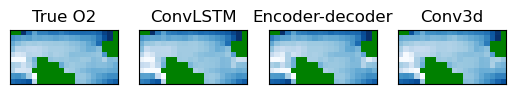

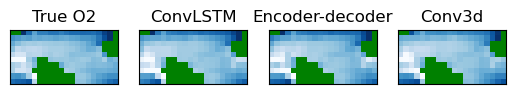

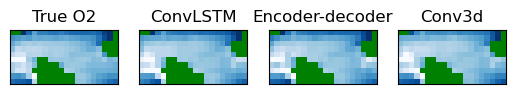

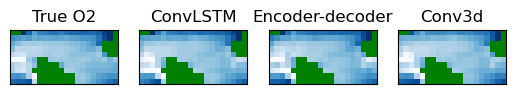

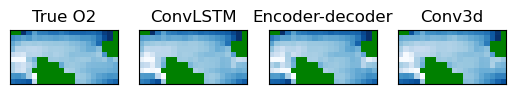

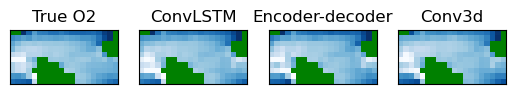

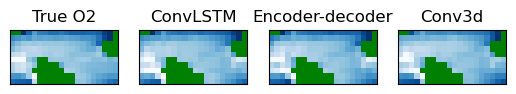

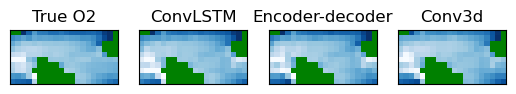

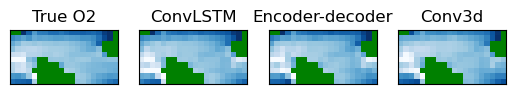

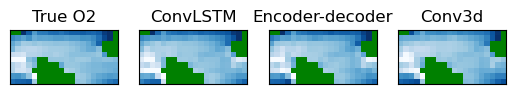

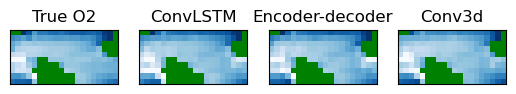

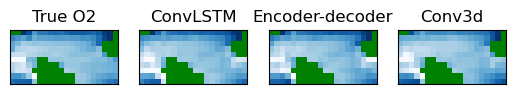

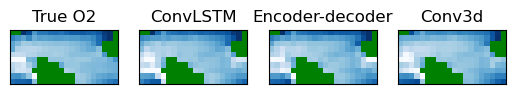

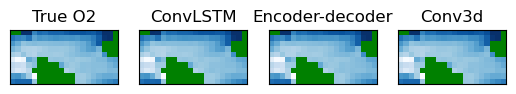

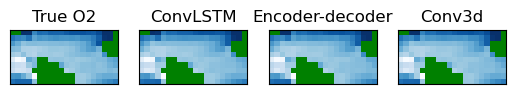

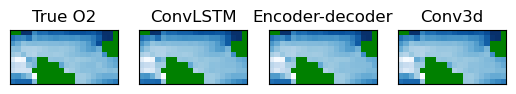

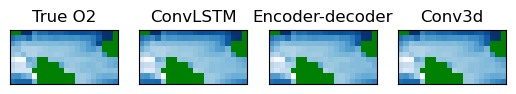

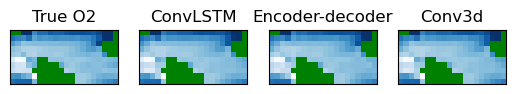

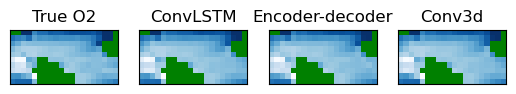

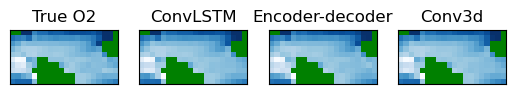

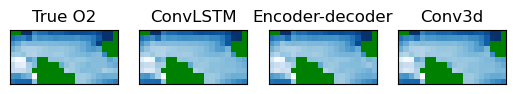

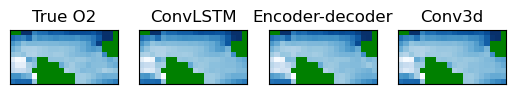

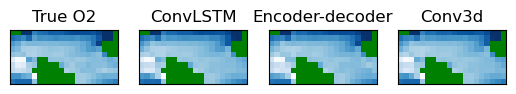

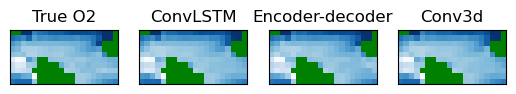

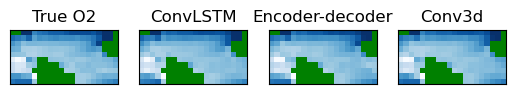

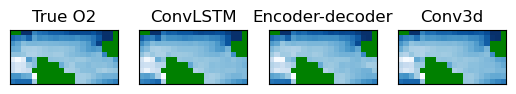

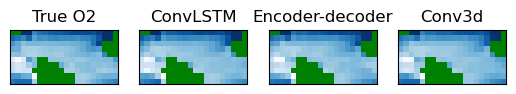

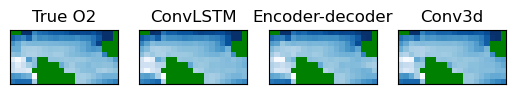

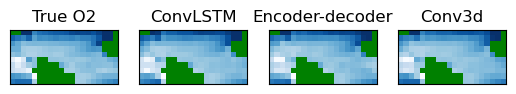

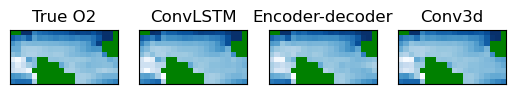

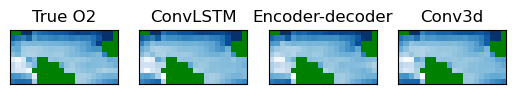

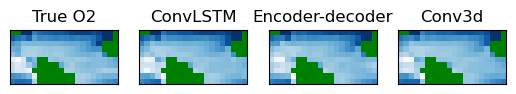

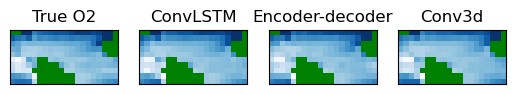

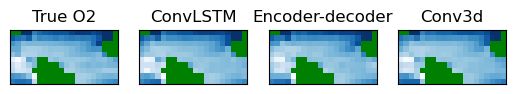

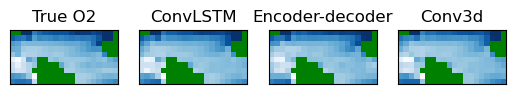

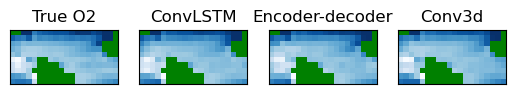

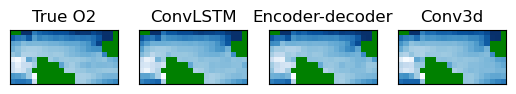

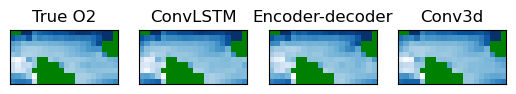

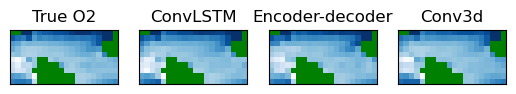

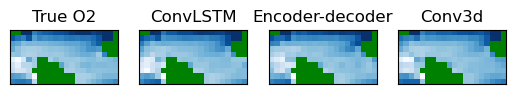

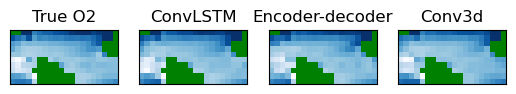

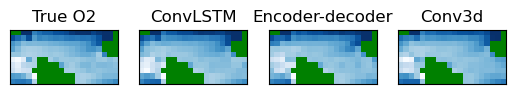

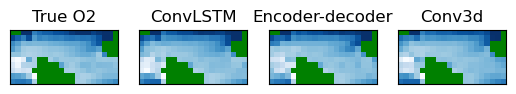

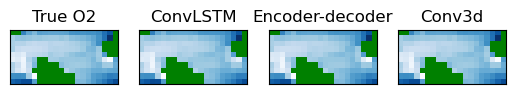

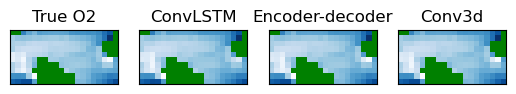

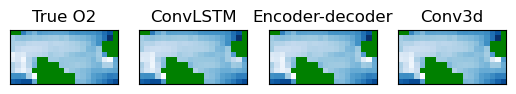

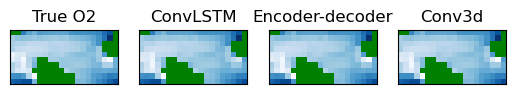

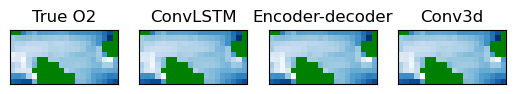

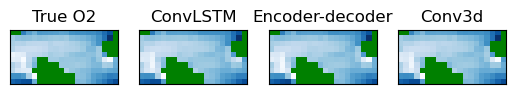

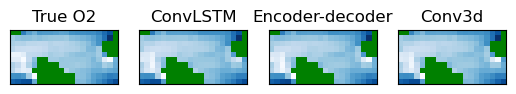

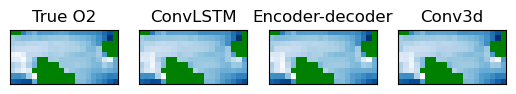

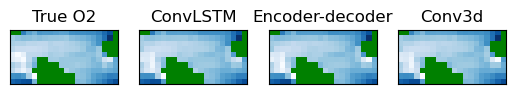

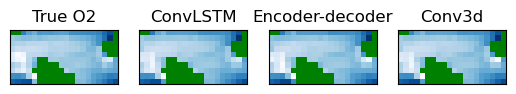

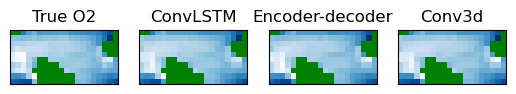

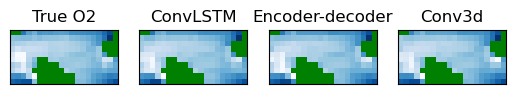

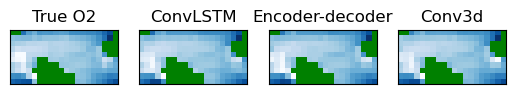

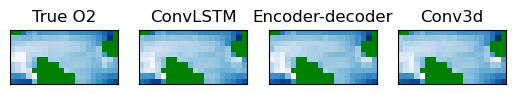

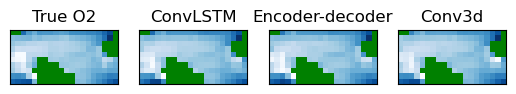

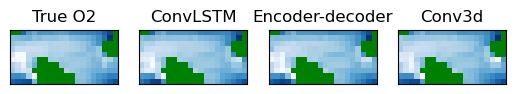

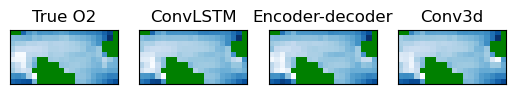

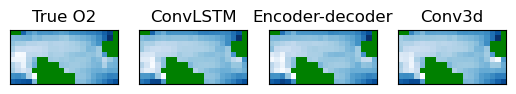

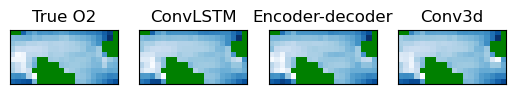

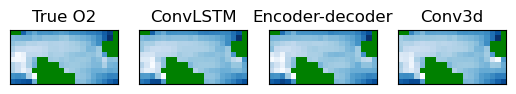

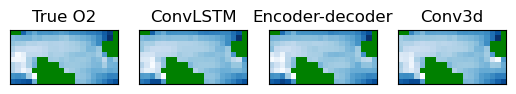

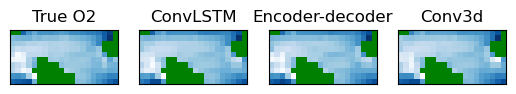

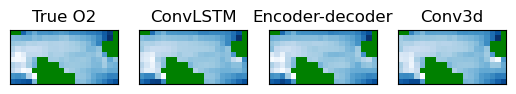

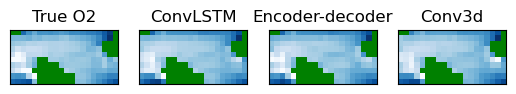

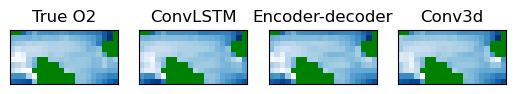

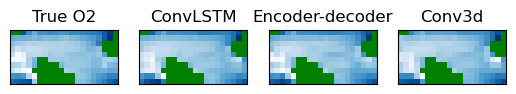

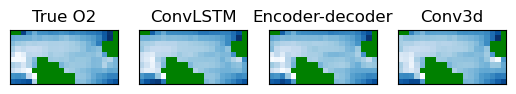

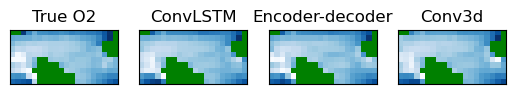

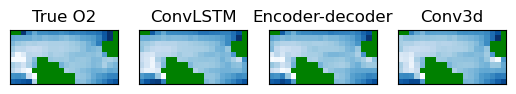

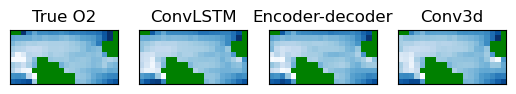

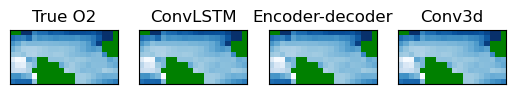

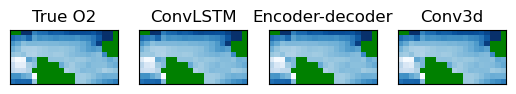

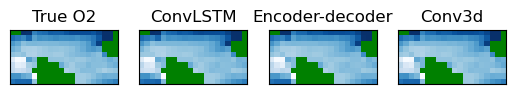

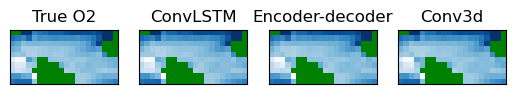

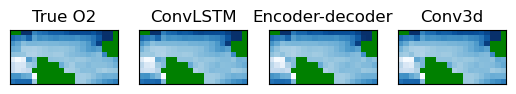

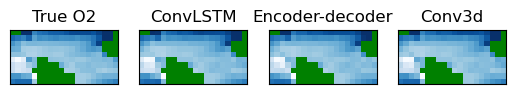

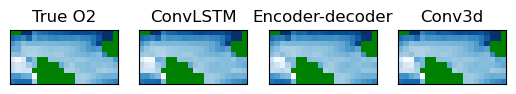

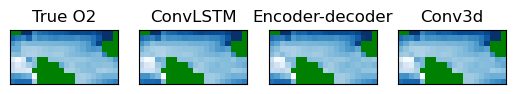

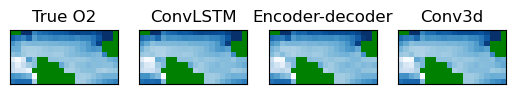

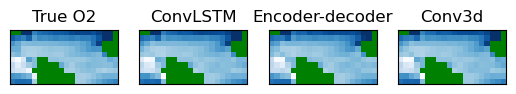

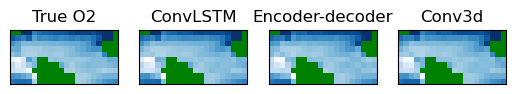

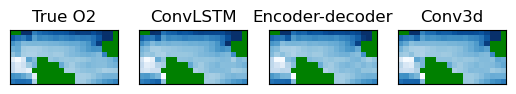

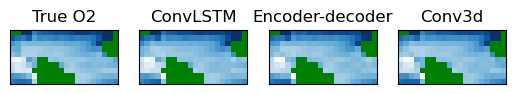

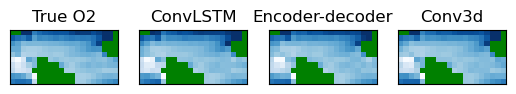

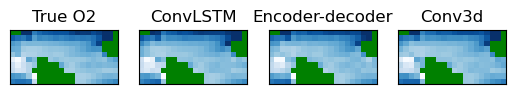

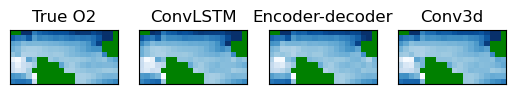

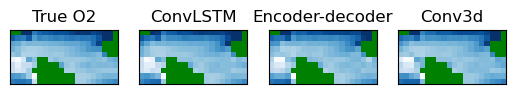

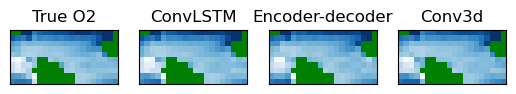

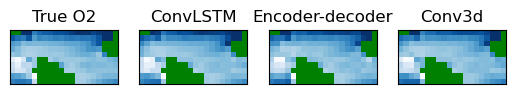

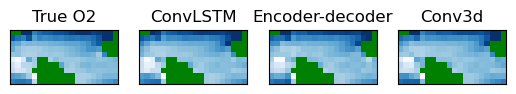

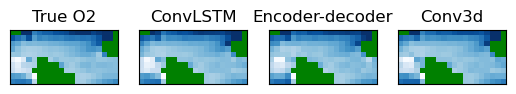

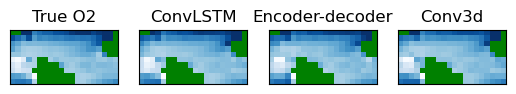

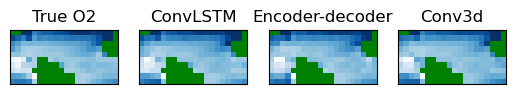

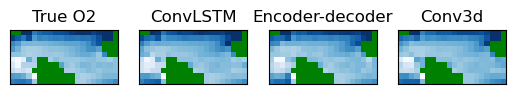

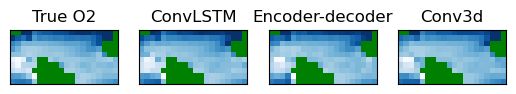

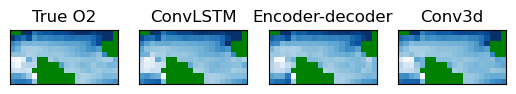

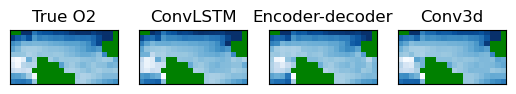

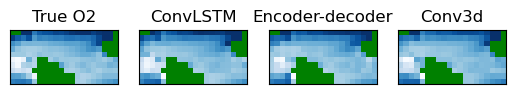

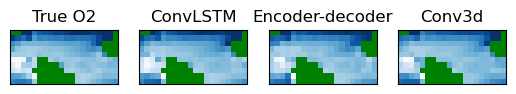

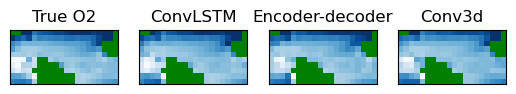

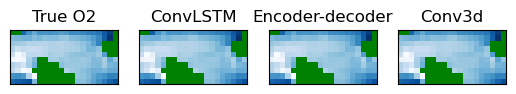

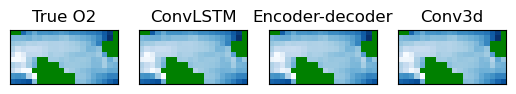

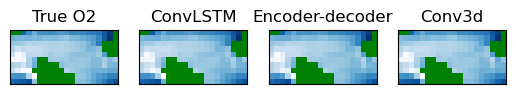

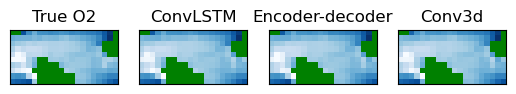

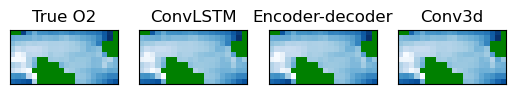

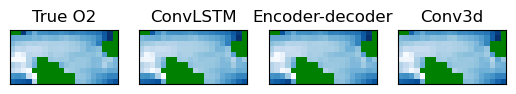

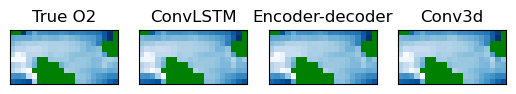

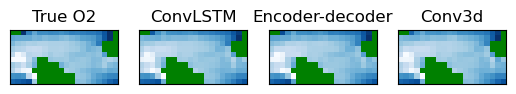

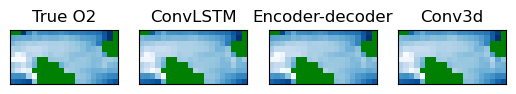

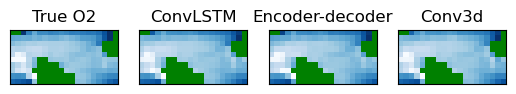

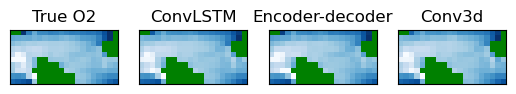

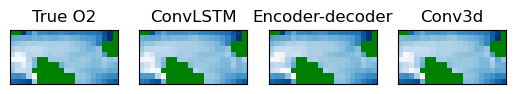

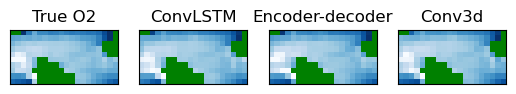

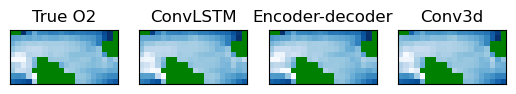

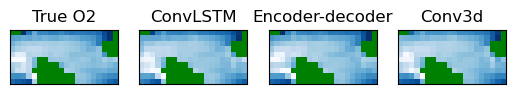

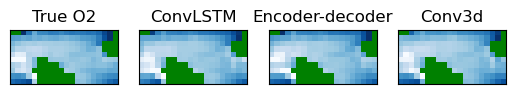

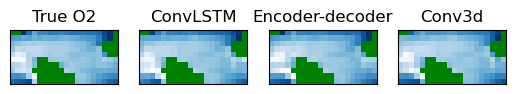

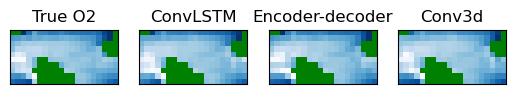

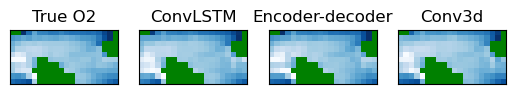

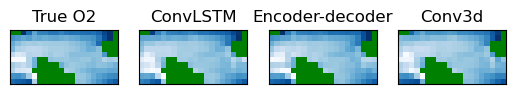

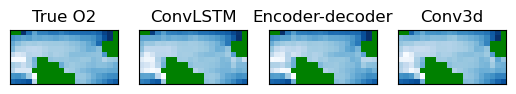

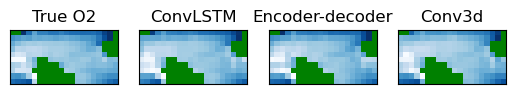

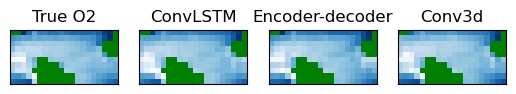

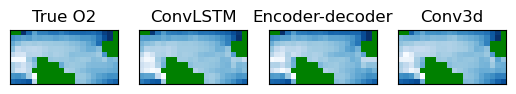

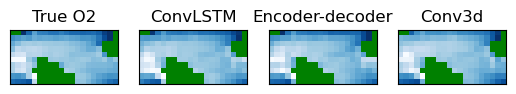

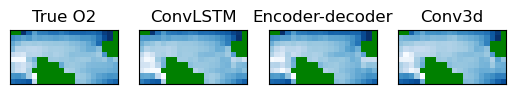

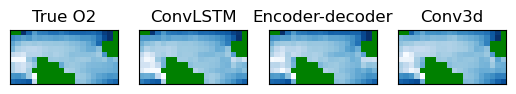

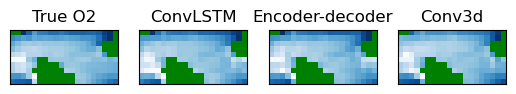

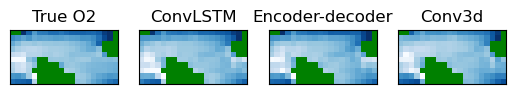

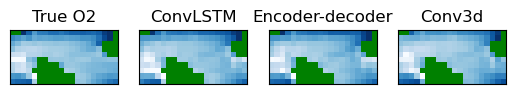

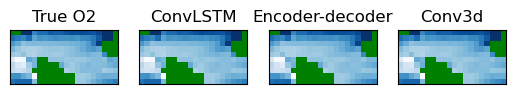

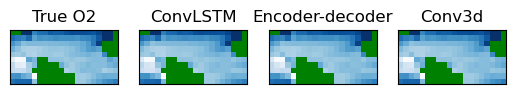

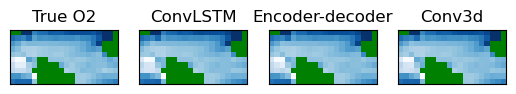

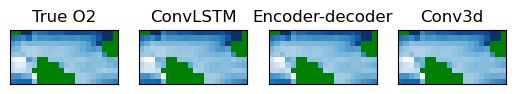

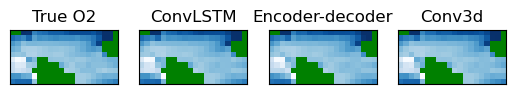

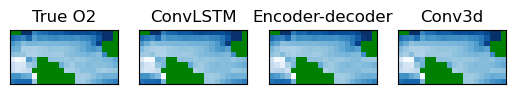

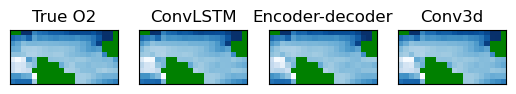

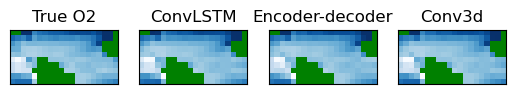

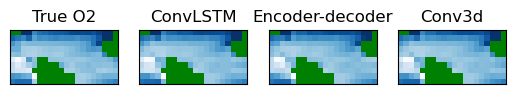

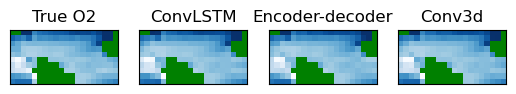

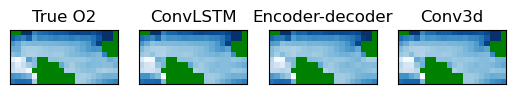

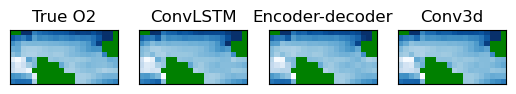

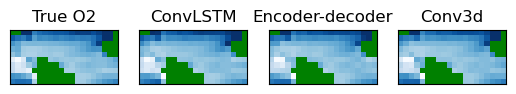

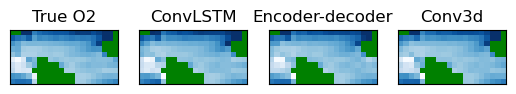

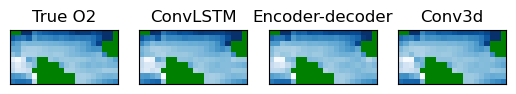

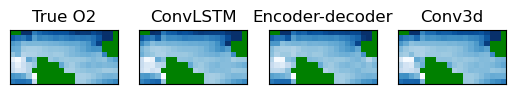

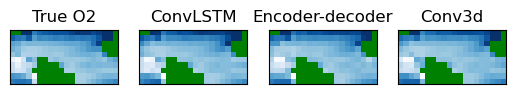

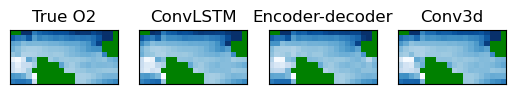

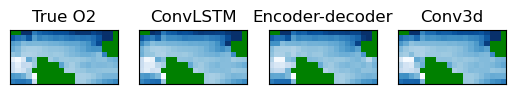

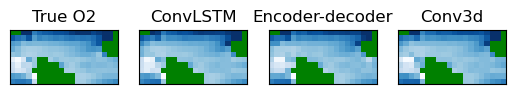

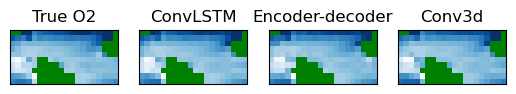

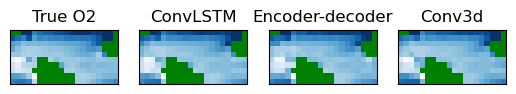

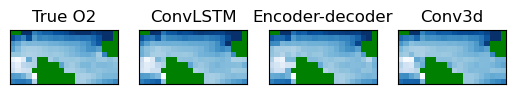

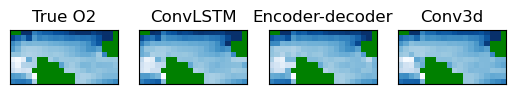

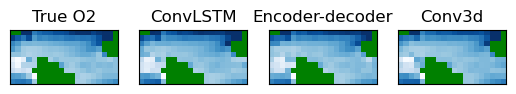

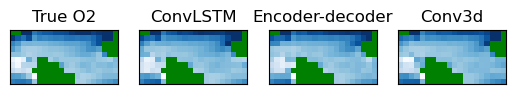

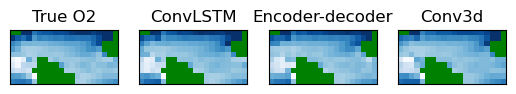

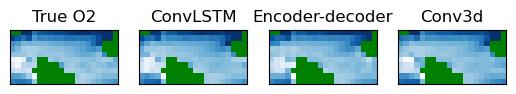

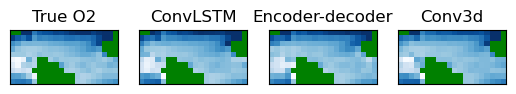

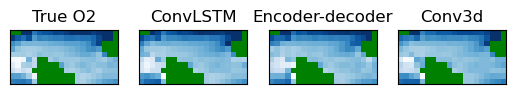

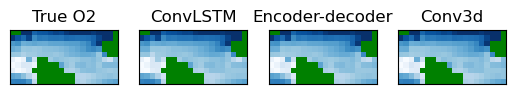

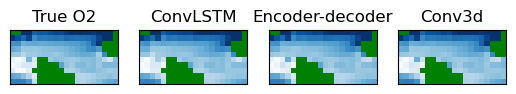

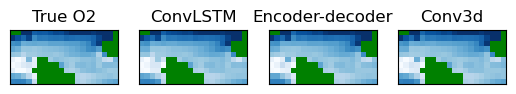

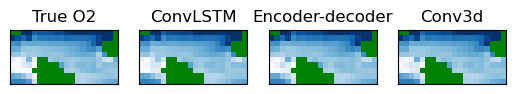

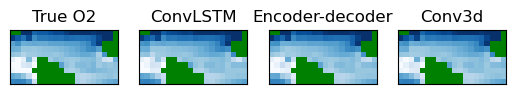

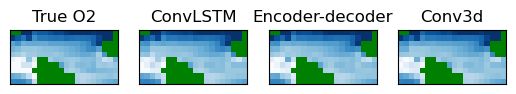

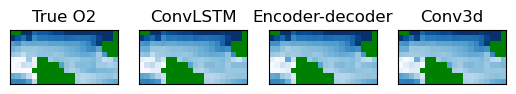

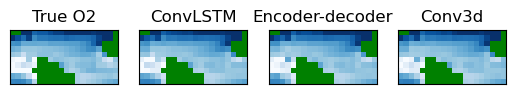

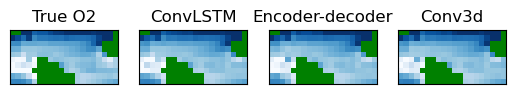

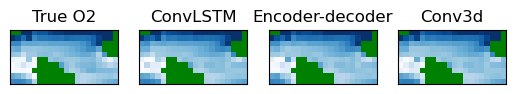

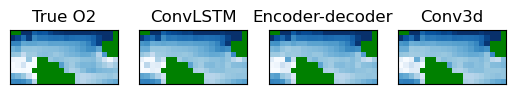

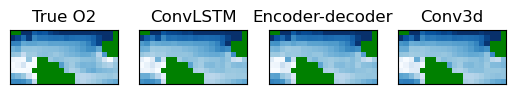

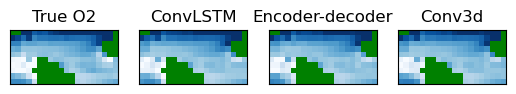

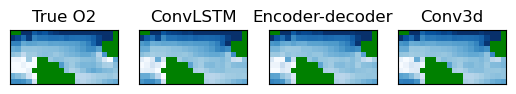

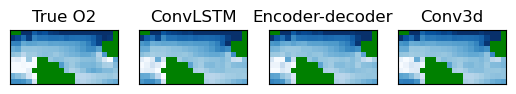

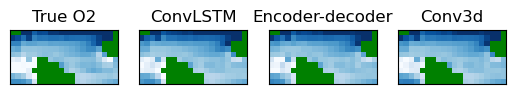

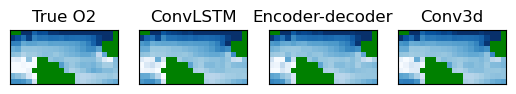

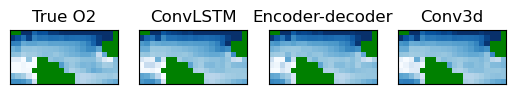

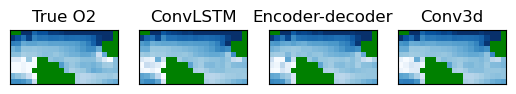

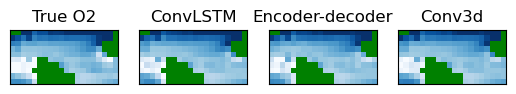

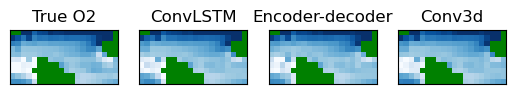

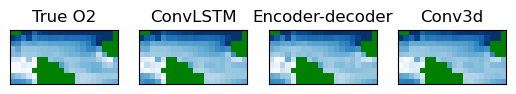

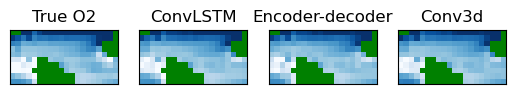

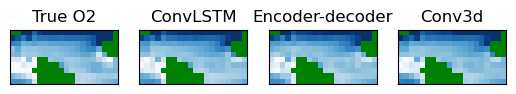

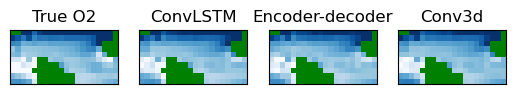

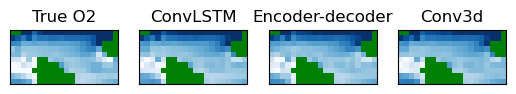

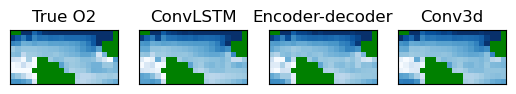

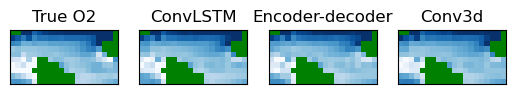

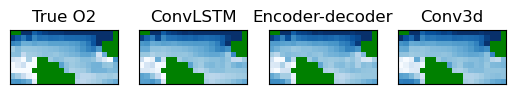

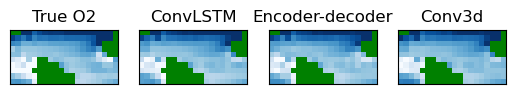

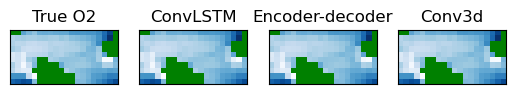

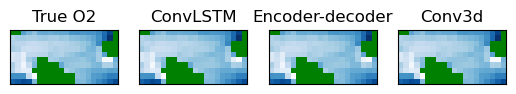

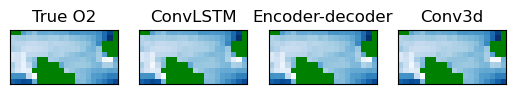

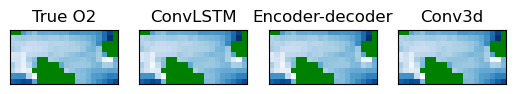

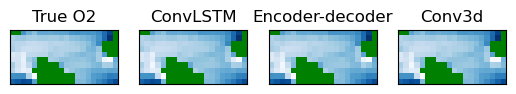

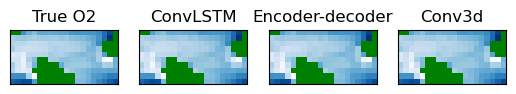

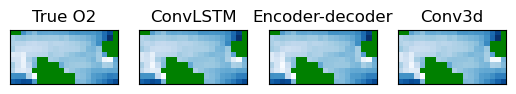

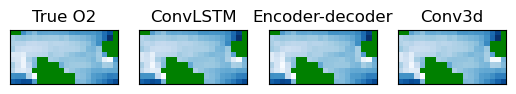

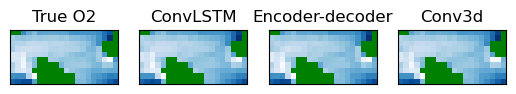

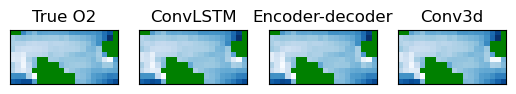

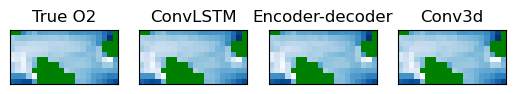

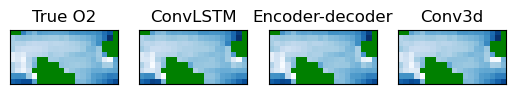

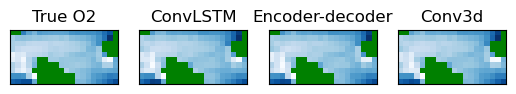

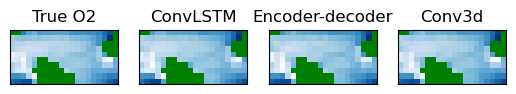

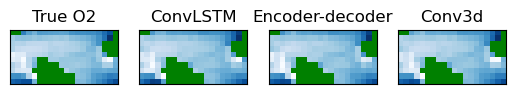

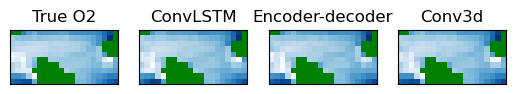

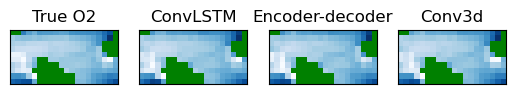

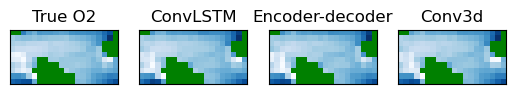

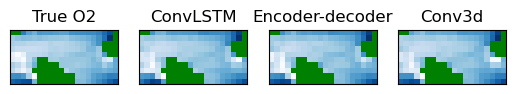

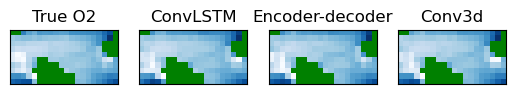

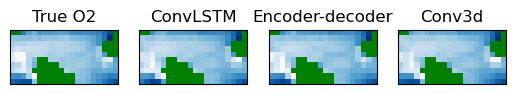

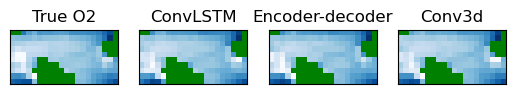

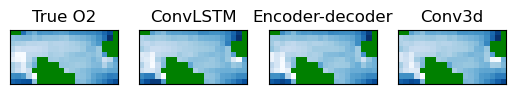

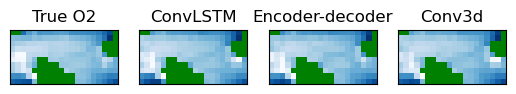

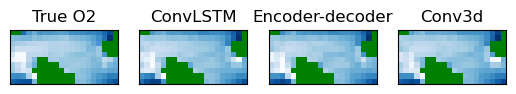

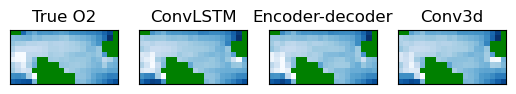

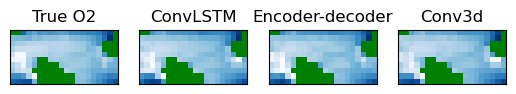

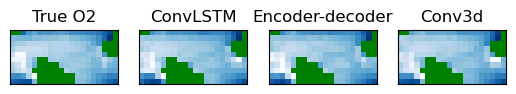

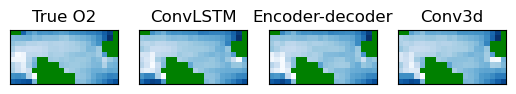

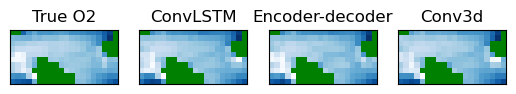

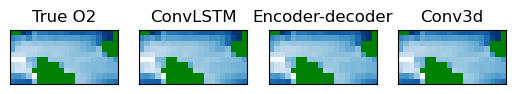

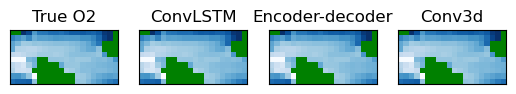

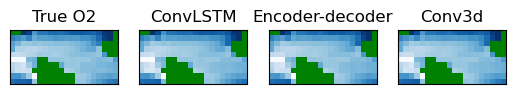

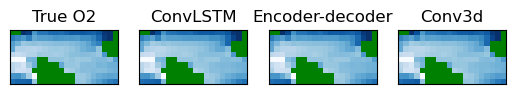

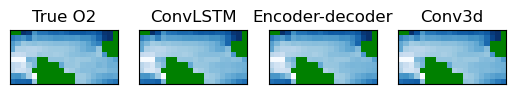

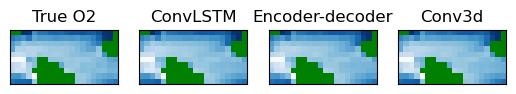

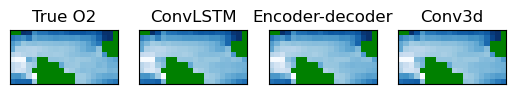

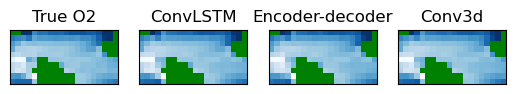

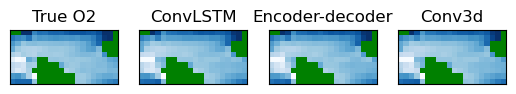

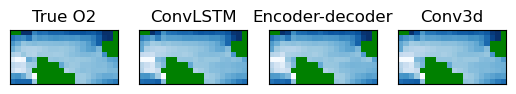

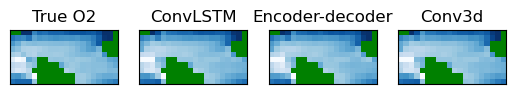

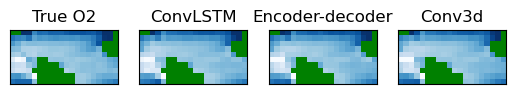

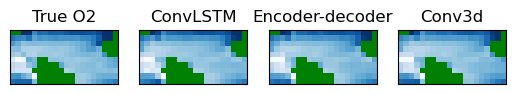

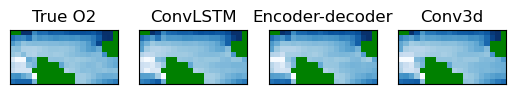

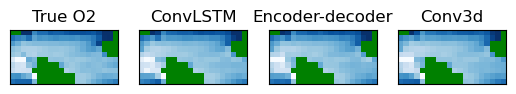

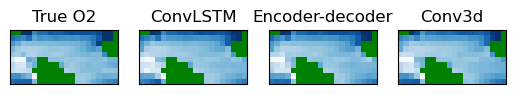

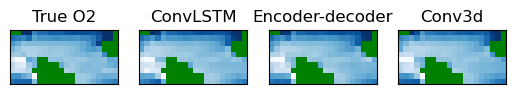

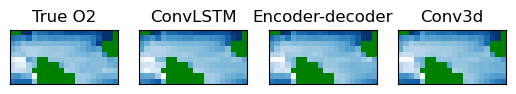

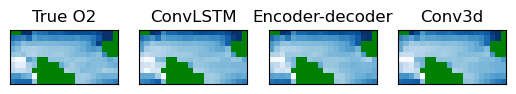

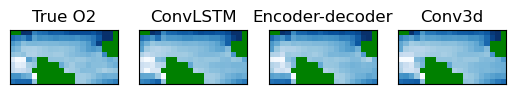

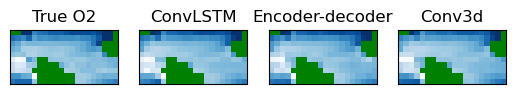

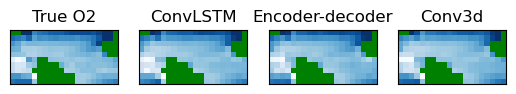

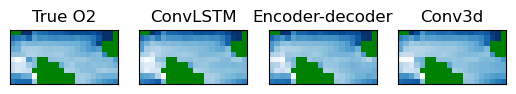

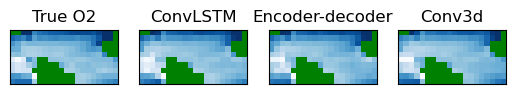

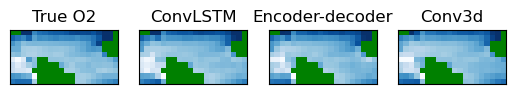

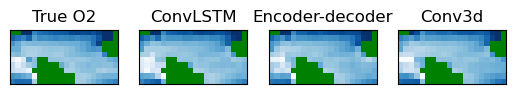

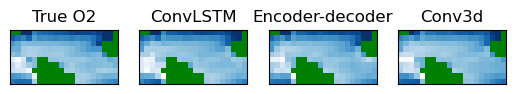

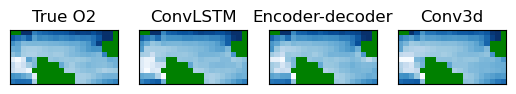

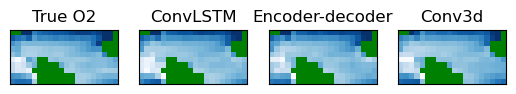

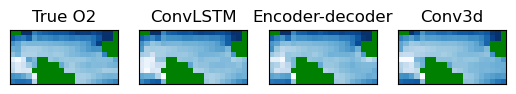

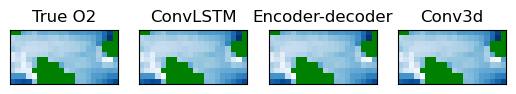

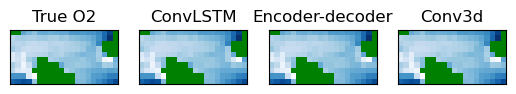

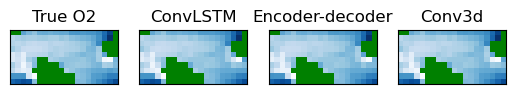

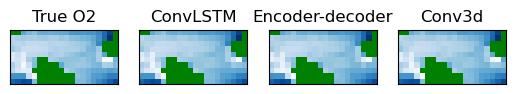

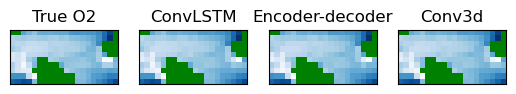

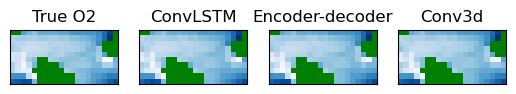

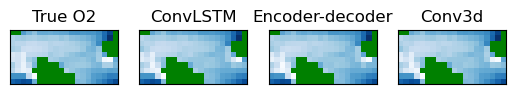

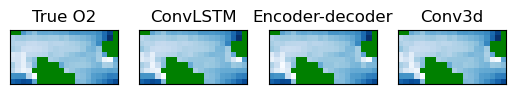

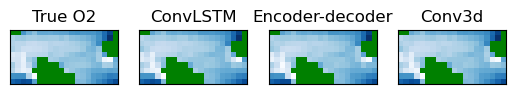

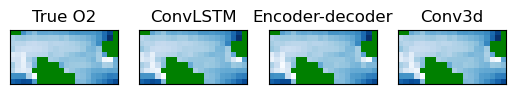

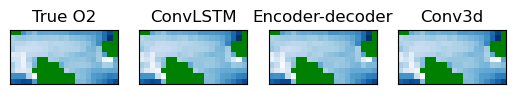

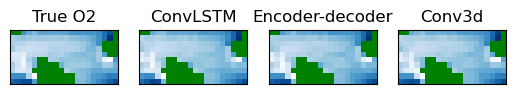

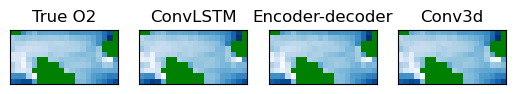

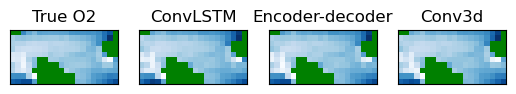

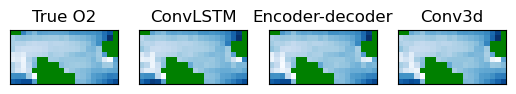

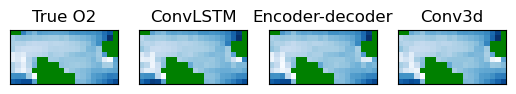

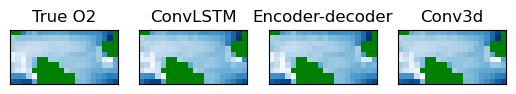

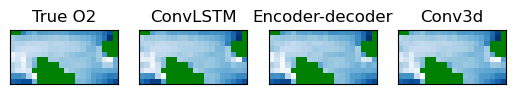

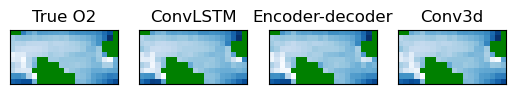

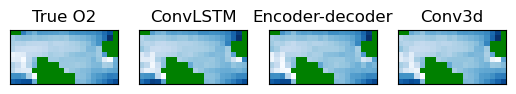

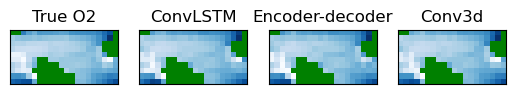

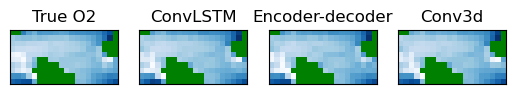

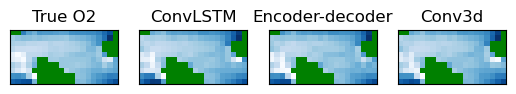

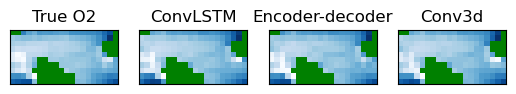

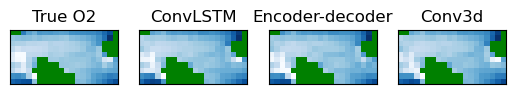

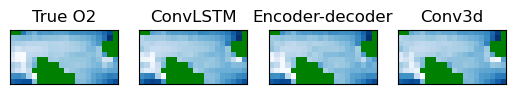

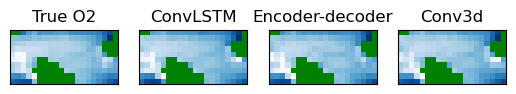

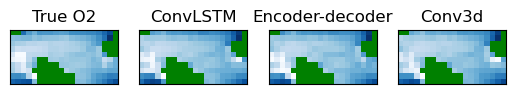

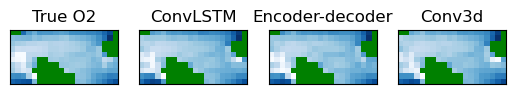

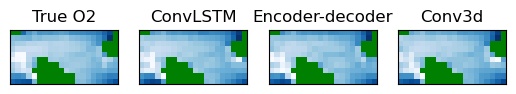

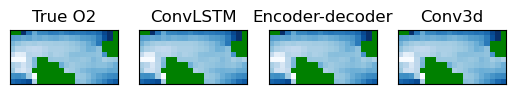

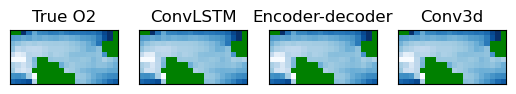

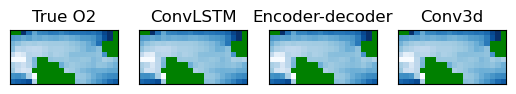

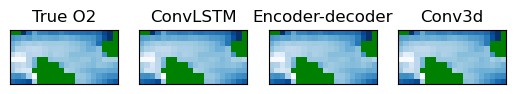

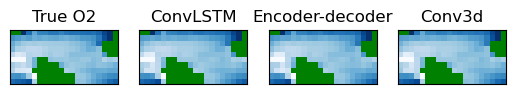

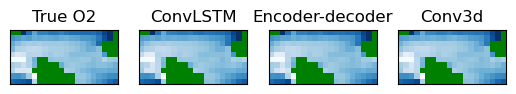

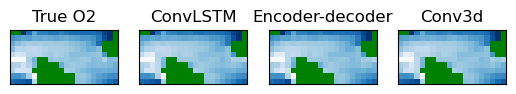

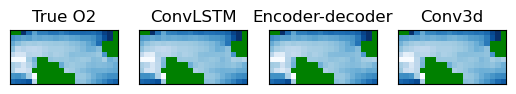

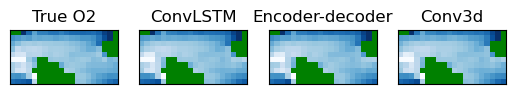

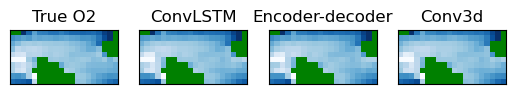

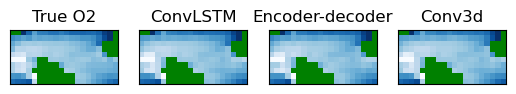

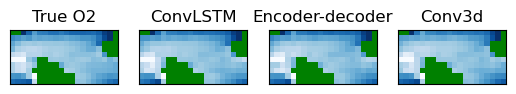

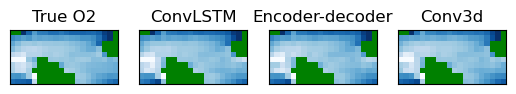

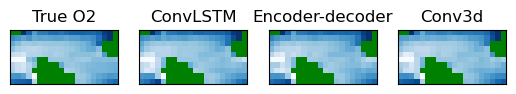

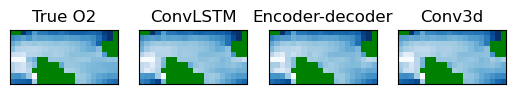

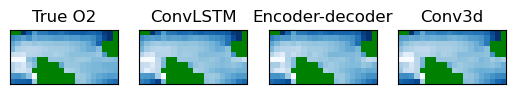

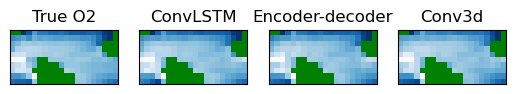

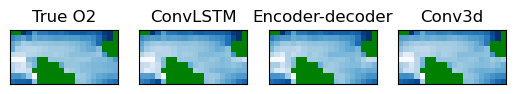

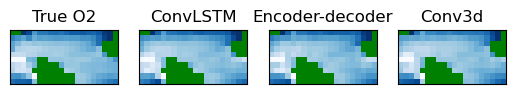

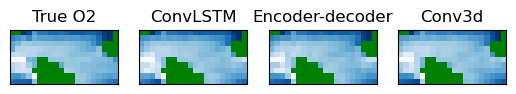

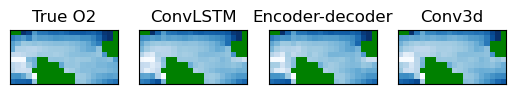

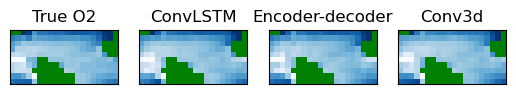

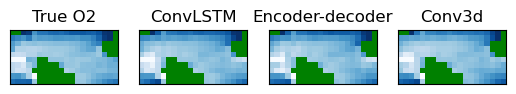

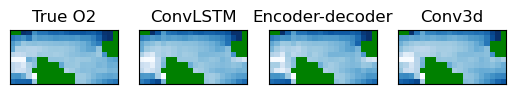

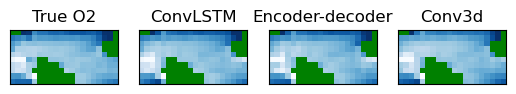

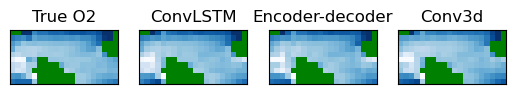

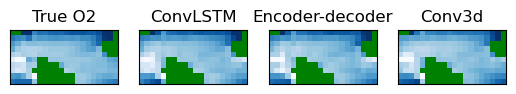

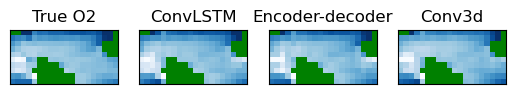

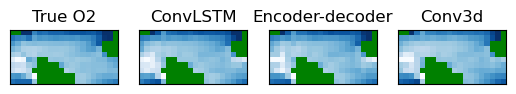

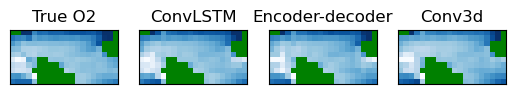

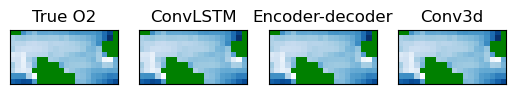

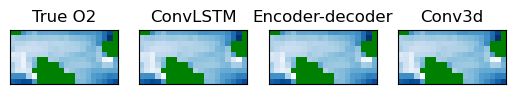

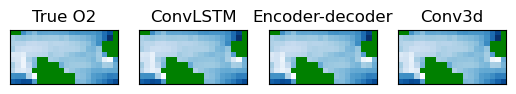

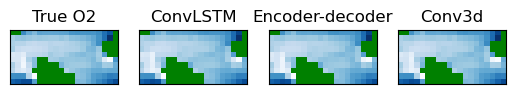

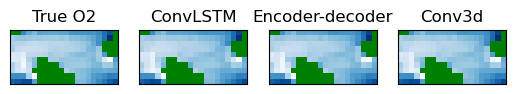

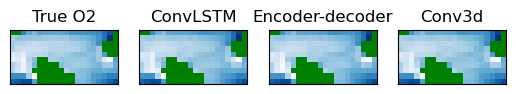

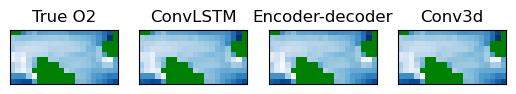

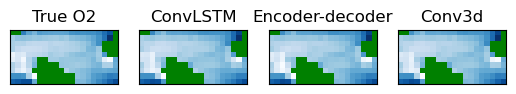

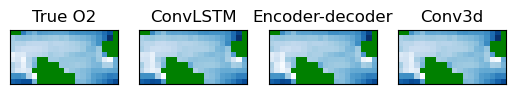

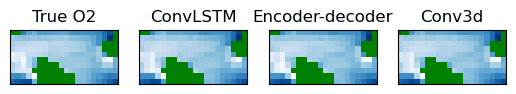

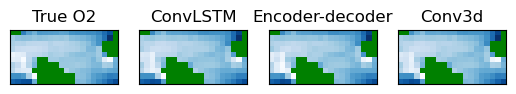

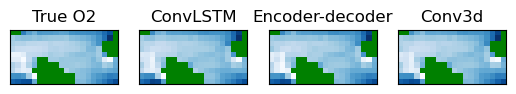

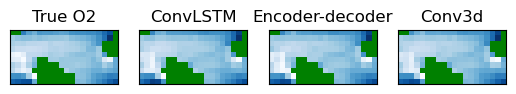

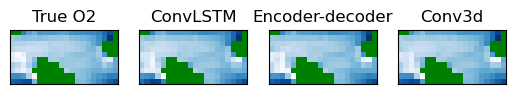

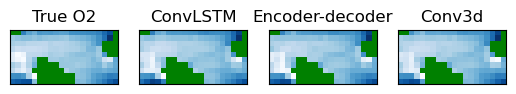

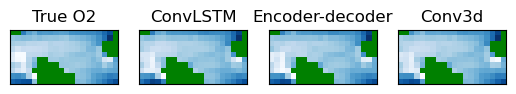

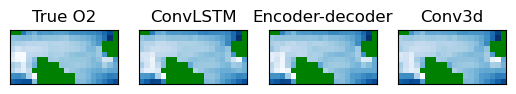

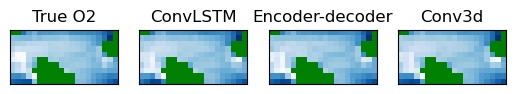

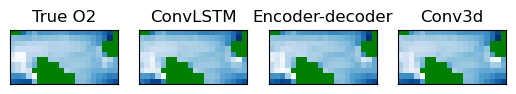

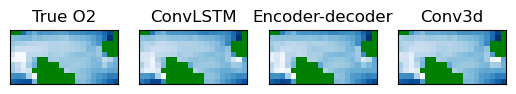

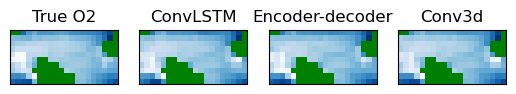

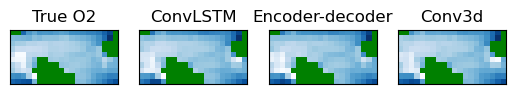

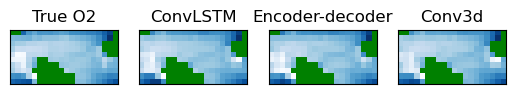

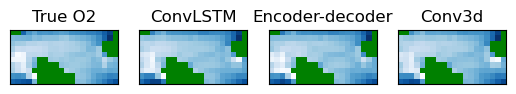

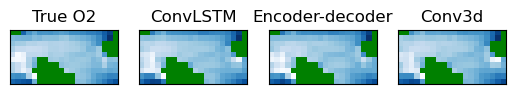

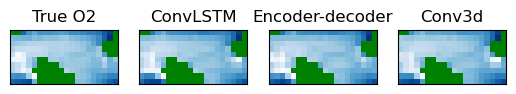

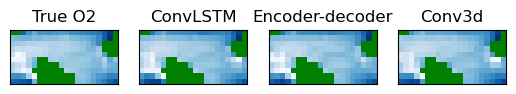

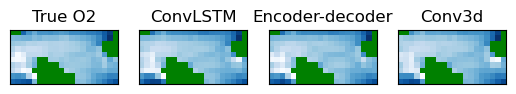

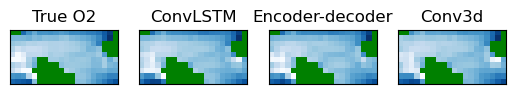

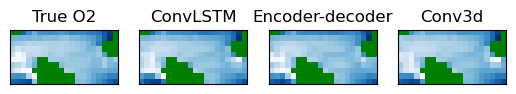

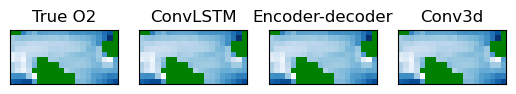

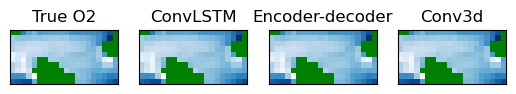

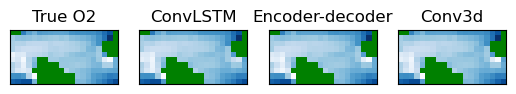

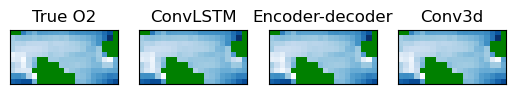

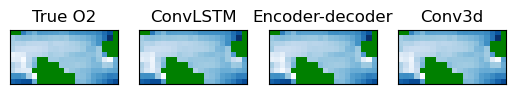

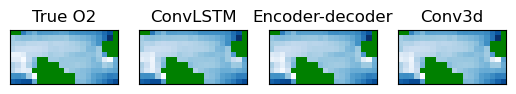

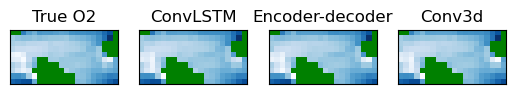

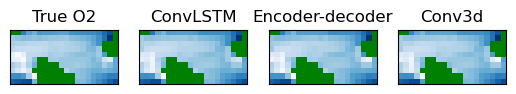

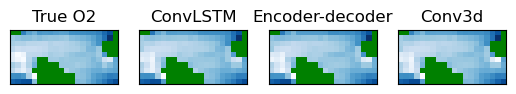

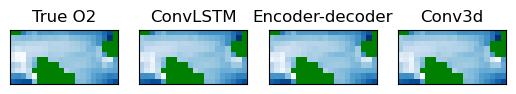

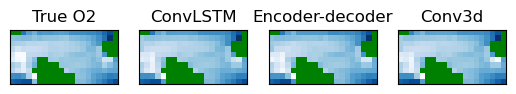

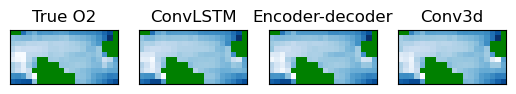

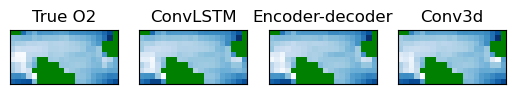

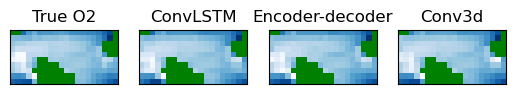

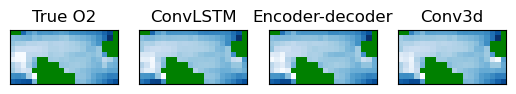

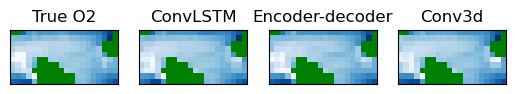

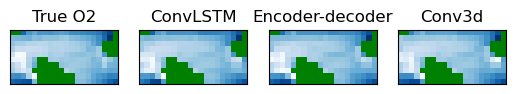

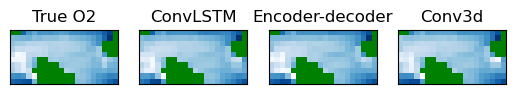

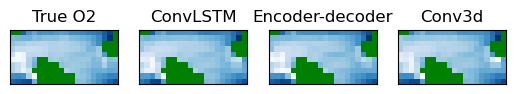

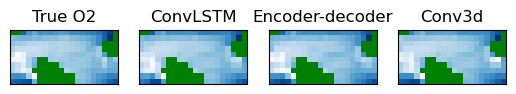

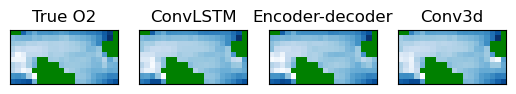

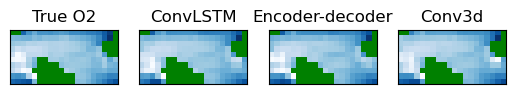

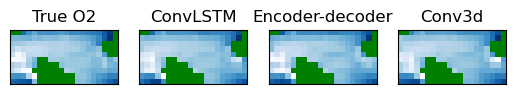

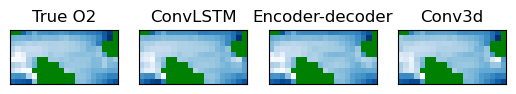

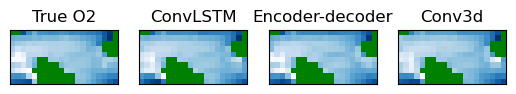

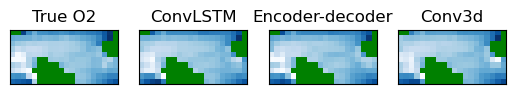

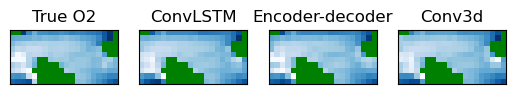

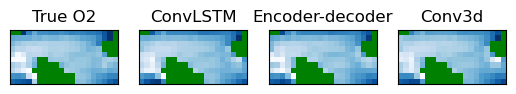

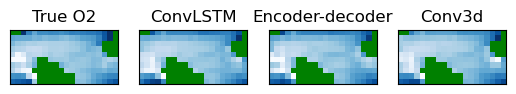

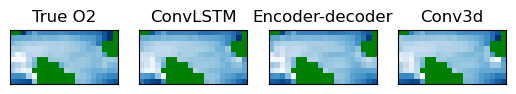

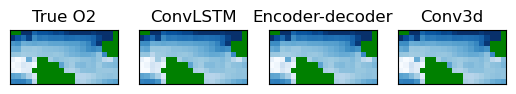

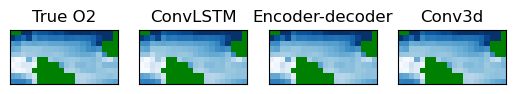

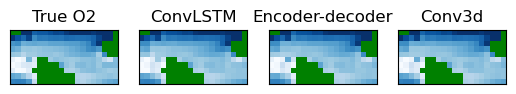

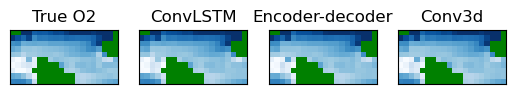

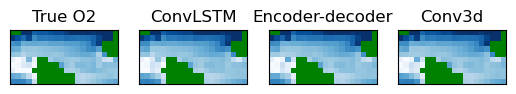

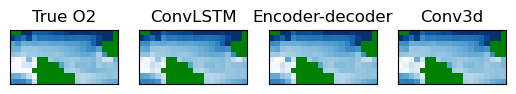

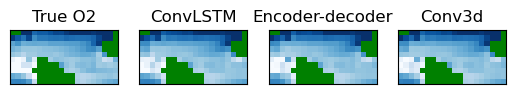

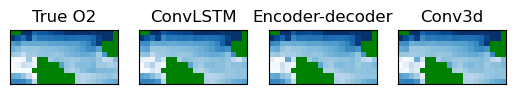

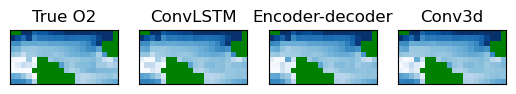

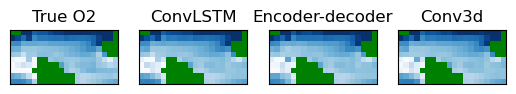

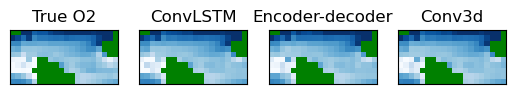

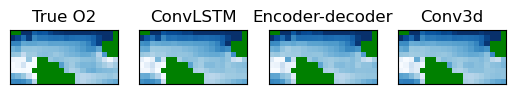

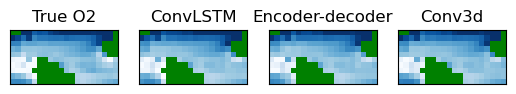

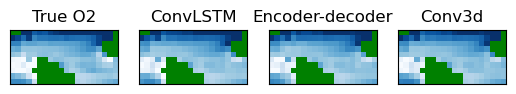

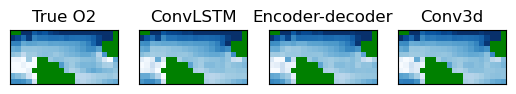

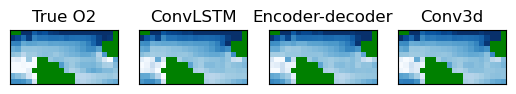

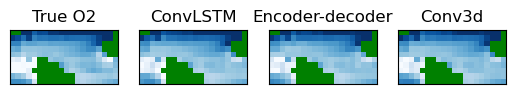

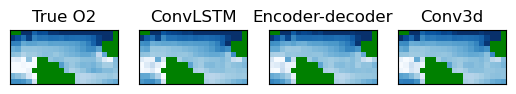

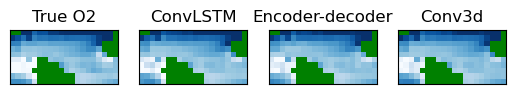

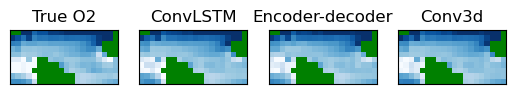

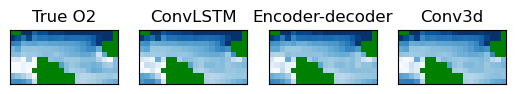

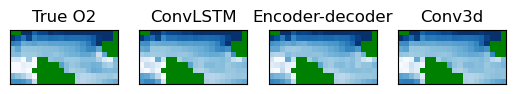

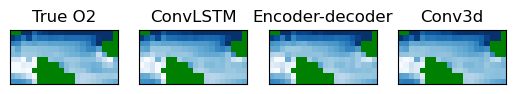

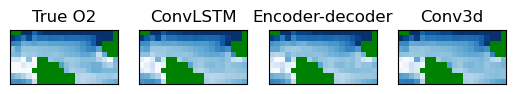

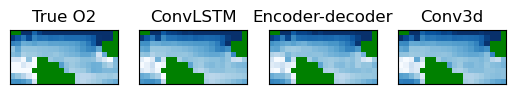

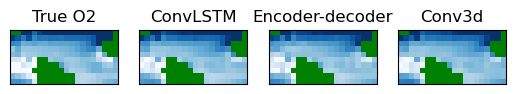

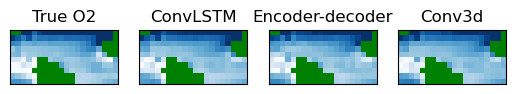

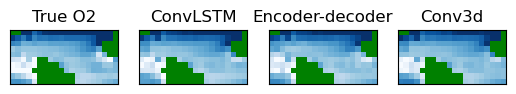

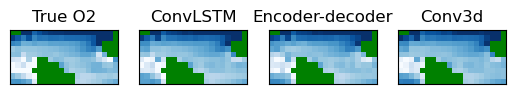

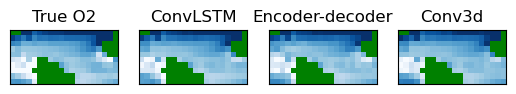

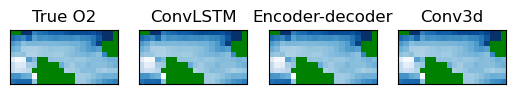

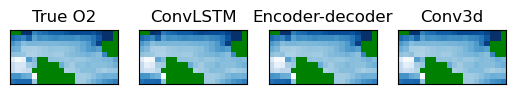

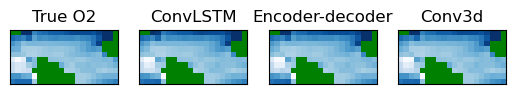

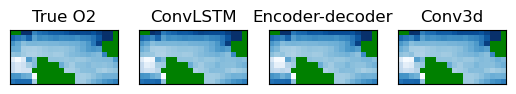

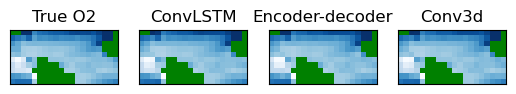

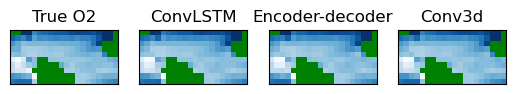

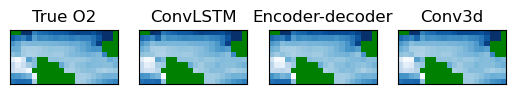

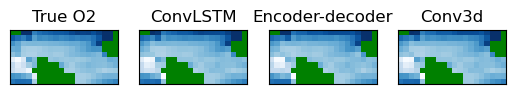

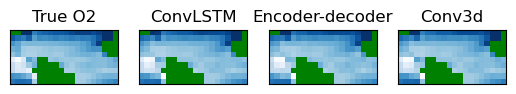

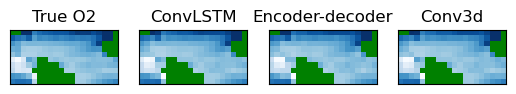

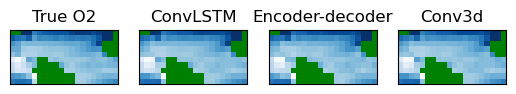

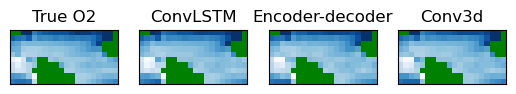

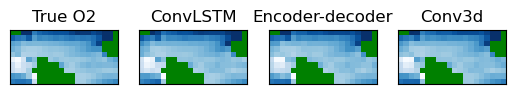

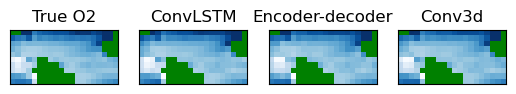

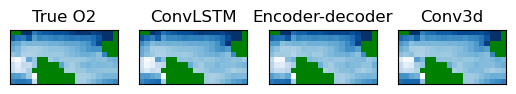

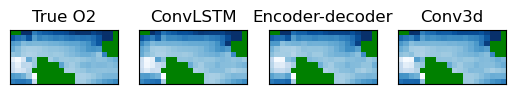

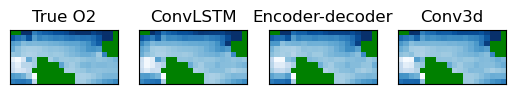

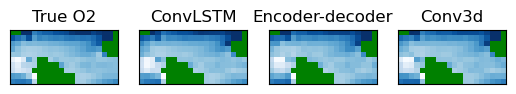

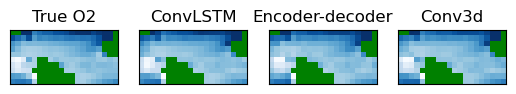

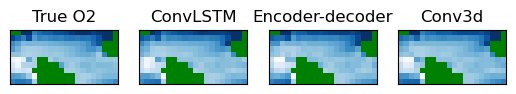

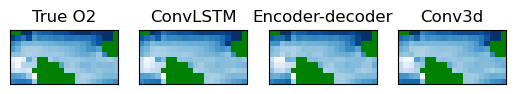

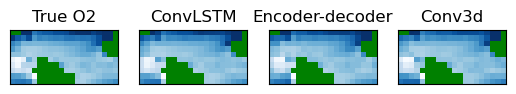

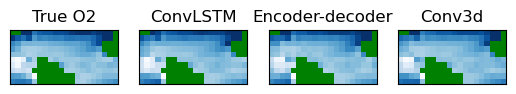

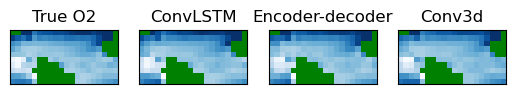

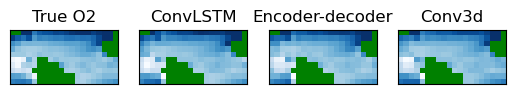

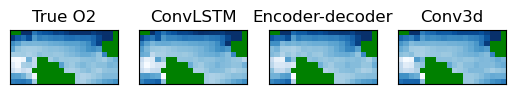

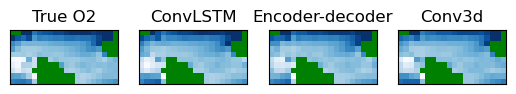

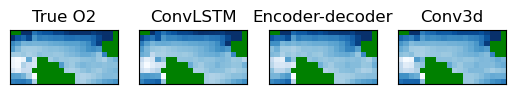

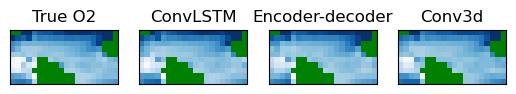

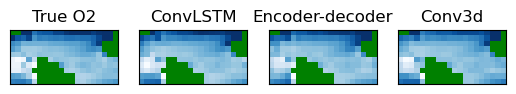

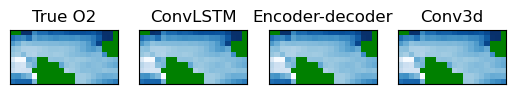

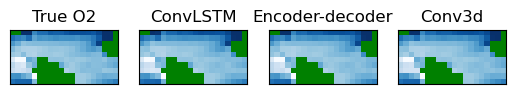

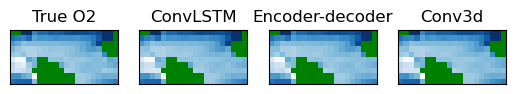

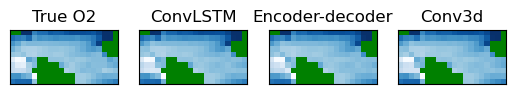

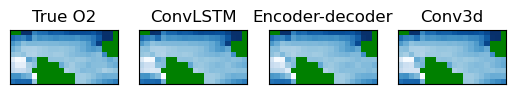

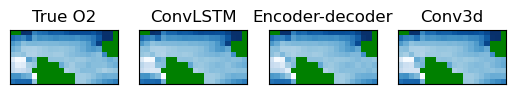

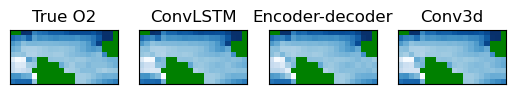

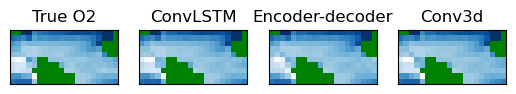

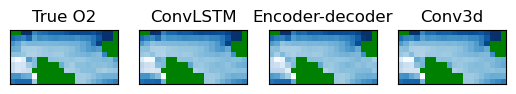

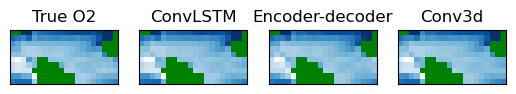

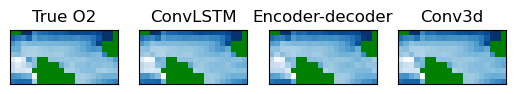

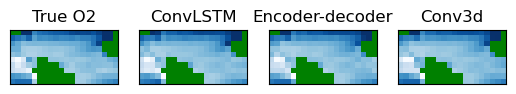

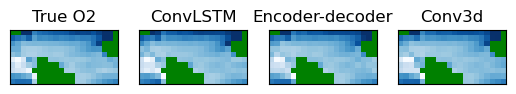

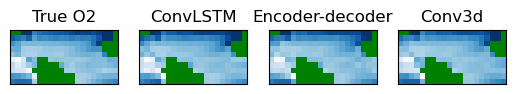

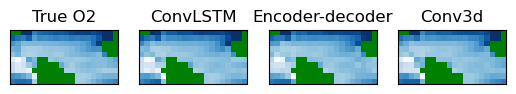

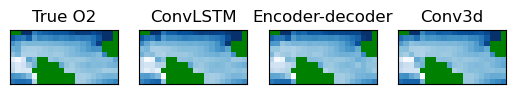

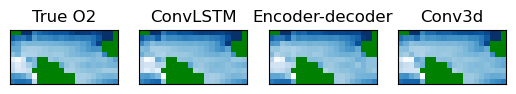

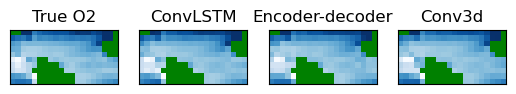

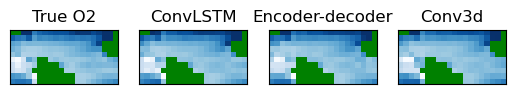

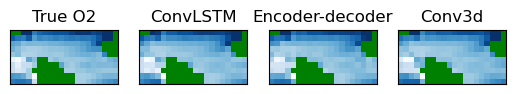

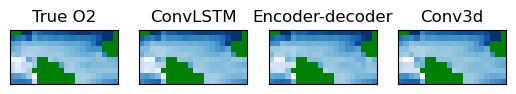

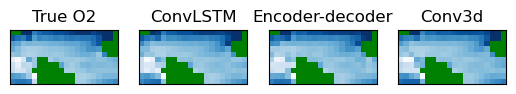

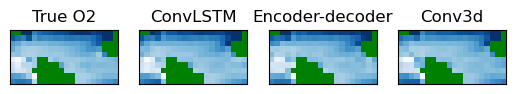

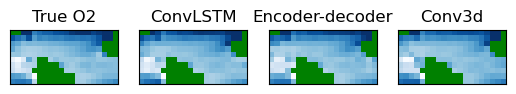

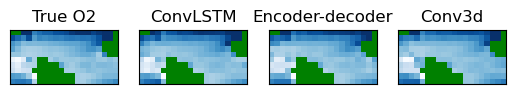

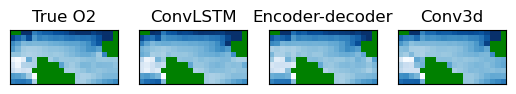

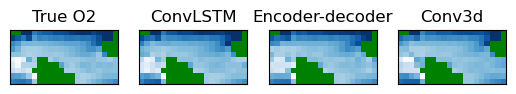

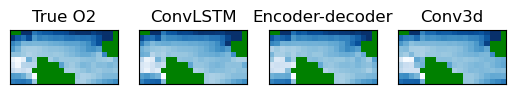

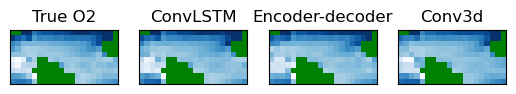

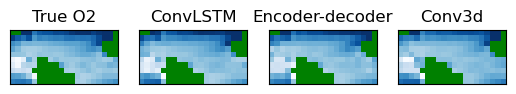

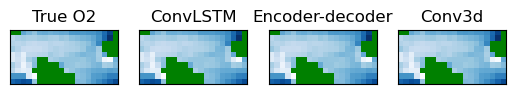

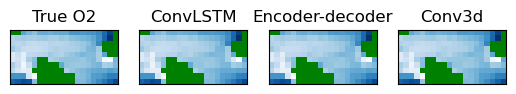

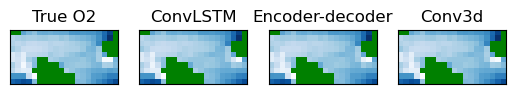

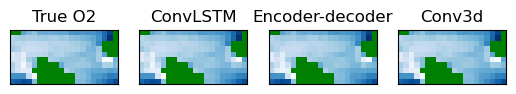

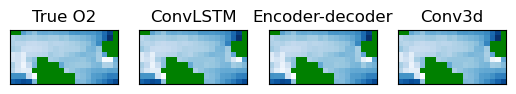

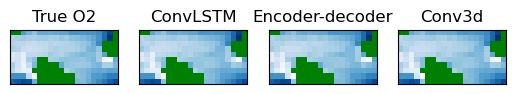

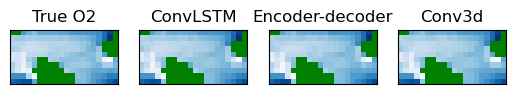

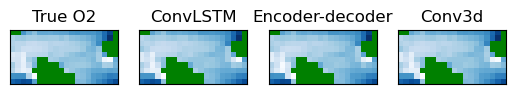

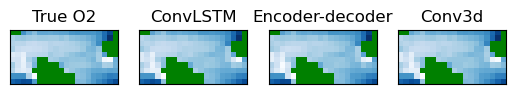

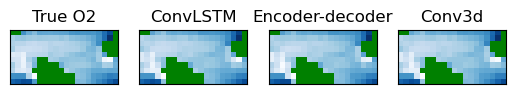

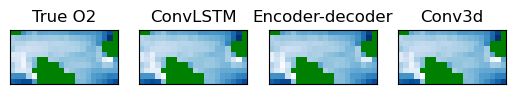

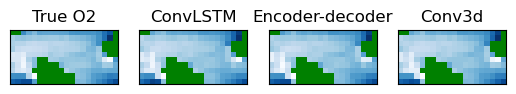

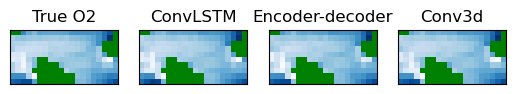

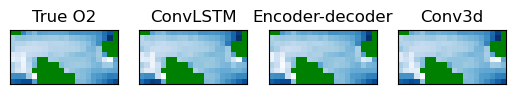

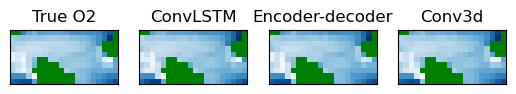

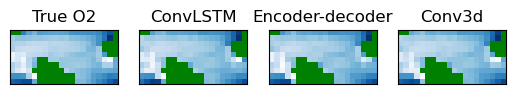

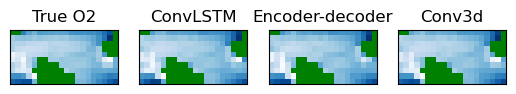

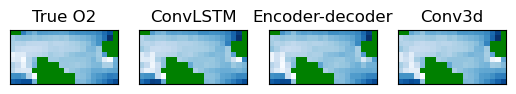

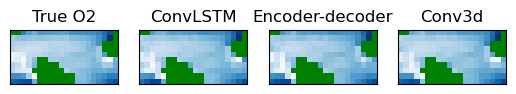

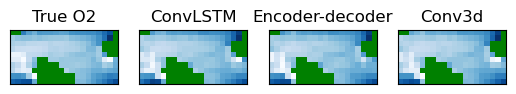

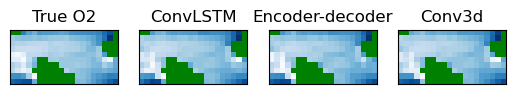

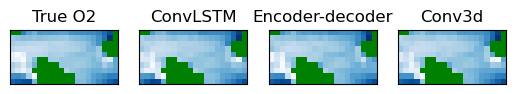

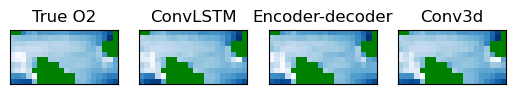

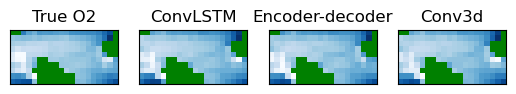

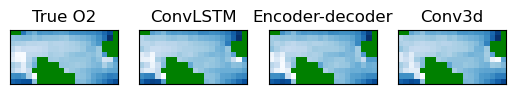

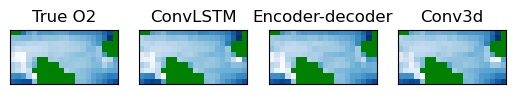

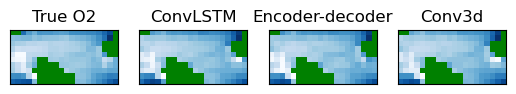

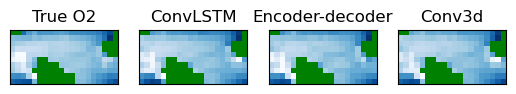

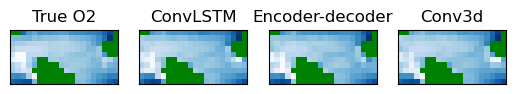

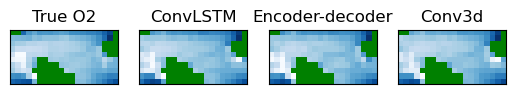

In [424]:
for i, idx in enumerate(sample_indices):
    for j in range(30):
        fig, axs = plt.subplots(1,4)
        for ax in axs:
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
        axs[0].set_title('True O2')
        axs[0].imshow(y_true[i,j], cmap=cmap, vmin=-2, vmax=2, origin='lower')
        axs[1].set_title('ConvLSTM')
        axs[1].imshow(y_pred_convlstm[i,j], cmap=cmap, vmin=-2, vmax=2, origin='lower')
        axs[2].set_title('Encoder-decoder')
        axs[2].imshow(y_pred_encoder_decoder[i,j], cmap=cmap, vmin=-2, vmax=2, origin='lower')
        axs[3].set_title('Conv3d')
        axs[3].imshow(y_pred_conv3d[i,j], cmap=cmap, vmin=-2, vmax=2, origin='lower')
        plt.savefig(f'./make_gif/date_{idx}_frame_{j}.jpeg', format='jpeg')

In [425]:
for idx in sample_indices:
    filenames = [f'./make_gif/date_{idx}_frame_{i}.jpeg' for i in range(30)]
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave(f'./gifs/comparison_date_{idx}.gif', images)

/var/folders/h9/7qb3ygvs0mzb0cdjbh8z8svr0000gn/T/ipykernel_43671/444798893.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
